In [1]:
# Trench run example
# Start with 2D Example of trench run (this is a metaphor for urban canyon), and then migrate to 3D example
# TODO
# 1. 3D

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Wrap2Pi
# Wrap around 2Pi for easier understanding
def wrap2pi(x):
    return x%(2*np.pi)

In [4]:
# Setup detection field
# n indicates number of grid cells for n x n grid
# Meshgrid X, Y created for n^2 number of cells with x, y values of 0 to xf, yf
n = 51
x = np.linspace(0, 5, n)
y = np.linspace(0, 5, n)
X,Y = np.meshgrid(x, y)

# Position function converting position index i_x to position x
def position(i_x):
    return np.array([x[i_x[0]], y[i_x[1]]])

# Define Initial, Final position of the aggressor
# Position index of aggressor
i_x0 = (int(0.05*n), int(0.05*n))
i_xf = (int(0.95*n), int(0.95*n))
# Position of aggressor
x0 = position(i_x0)
xf = position(i_xf)
print("x0: {}, xf: {}".format(x0, xf))

x0: [0.2 0.2], xf: [4.8 4.8]


In [5]:
# Building Setup
# Set nB number of buildings
# building_i indicates 4 corners of the building generated in the field
nB = 2
building1 = np.array([0, 1.5, 1, 4])
building2 = np.array([3.5, 5, 1, 4])
building = [building1, building2]

In [6]:
# Camera Setup
# camx: x coordinate of camera
# camy: y coordinate of camera
# cam_direc: Center of camera tilt angle limits
camx = np.array([1.5, 3.5, 1.5, 3.5])
camy = np.array([1, 1, 4, 4])
cam_direc = np.array([np.pi*7/4, np.pi*5/4, np.pi*1/4, np.pi*3/4])

# Camera Hardware Constants
# These values are pre-determined by hardware spec given from manufacturer
tilt_limit = [0, np.pi]
fov_ang = np.deg2rad(20) # [rad]
#fov_rng = 0.475 # [m]
fov_rng = .9 # [m]


# Function computing a vector containing camera angle at given specific time t
def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t)-1)
    dt = t[1]-t[0]
    
    # Iteration until it hits the angle limit
    iter_lim = 2*(ang_lim[1]-ang_lim[0])/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim/2:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        
        # Store the computed current angle into storage vector
        fov_ang_vec[i] = fov_ang_curr
    return fov_ang_vec

# Function computing a camera properites
# Assume all cameras are identical
def camera_setup(camx, camy, cam_direc):
    # n_cam: number of camera
    # rot_vel: angular velocity of camera movement
    n_cam = len(camx)
    rot_vel = 2*(tilt_limit[1]-tilt_limit[0])/n # [rad/unit time]
    endtime = int(tilt_limit[1]*2/rot_vel)
    
    # Initialize empty storages
    ang_lim = np.zeros((n_cam,2))
    start_ang = np.zeros((n_cam,1))    
    tvec = np.zeros((n_cam, int(tilt_limit[1]*2/rot_vel)))
    camvec = np.zeros((n_cam, tvec.shape[1]-1))
    
    # Compute camera properties for each camera
    # campos: position of the camera
    # start_ang: angle of the camera at given time
    # tvec: time vector which camera is operating
    # ang_lim: Limit of angle which camera can tilt
    # camvec: a vector including camera FOV's angle at given t
    for i in range(n_cam):
        ang_limi = [cam_direc[i]-(tilt_limit[1]-tilt_limit[0])/2, cam_direc[i]+(tilt_limit[1]-tilt_limit[0])/2]
        start_angi = ang_limi[0] # [rad]
        ti = np.linspace(0, endtime-1, endtime)
        
        # Store computed variables
        ang_lim[i,:] = ang_limi
        start_ang[i] = start_angi
        tvec[i,:] = ti
        
        # Compute fov_cam
        fov_ang_veci = fov_cam(start_angi, ang_limi, rot_vel, fov_ang, fov_rng, ti)
        camvec[i,:] = fov_ang_veci
        
    # Camera Positoin
    campos = np.array([camx, camy]).transpose()

    return campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec

# Obtain camera properties
campos, n_cam, rot_vel, start_ang, endtime, tvec, ang_lim, camvec = camera_setup(camx, camy, cam_direc)

# Check number mismatch
for i in range(n_cam):
    print("campos: {}, {}".format(campos[i,0], campos[i,1]))
print("camvec length: {}".format(len(camvec[0])))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = np.array([int(len(tvec[0])/2+20), int(len(tvec[1])/2)+20, int(len(tvec[2])/2)+20, int(len(tvec[2])/2)+20]) #random.randint(0, len(t)-1)
end_ang = np.array([camvec[0, end_in[0]], camvec[1, end_in[1]], camvec[2, end_in[2]], camvec[3, end_in[3]]]) # Arbirary number for now
if len(end_in) != n_cam:
    raise Exception("number of camera mismatch")
    print("end_index: {}, FOV angle at final point[deg]: {}".format(end_in, np.rad2deg(end_ang)))
for i in range(n_cam):
    print("end_index: {}, FOV angle at final point[deg]: {}, Tilt Limit: {}".format(end_in[i], np.rad2deg(end_ang[i]), np.rad2deg(ang_lim[i])))

campos: 1.5, 1.0
campos: 3.5, 1.0
campos: 1.5, 4.0
campos: 3.5, 4.0
camvec length: 50
end_index: 45, FOV angle at final point[deg]: 267.3529411764705, Tilt Limit: [225. 405.]
end_index: 45, FOV angle at final point[deg]: 177.3529411764706, Tilt Limit: [135. 315.]
end_index: 45, FOV angle at final point[deg]: -2.647058823529425, Tilt Limit: [-45. 135.]
end_index: 45, FOV angle at final point[deg]: 87.3529411764706, Tilt Limit: [ 45. 225.]


(-0.1, 5.1)

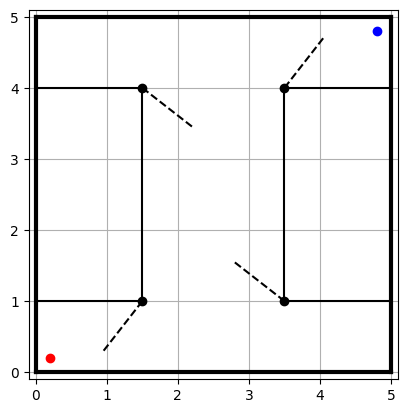

In [7]:
# Visualization for Initial Positions
fig = plt.figure()
# Visualization Purpose
for ind in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[ind,0], campos[ind,1], 'ok')

    # Plot Camera FOV
    #for k in range(len(camvec[ind])):
    #    theta = camvec[ind, k]
    #    xend = campos[ind,0]+fov_rng*np.cos(theta)
    #    yend = campos[ind,1]+fov_rng*np.sin(theta)
    #    plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--k')
    theta = camvec[ind, 0]
    xend = campos[ind,0]+fov_rng*np.cos(theta)
    yend = campos[ind,1]+fov_rng*np.sin(theta)
    plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--k')
        
# Building
for b in range(nB):
    bcoor = building[b]
    plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
    plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
    plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
    plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')

# Plot x0, xf
plt.plot(x0[0], x0[1], 'or')
plt.plot(xf[0], xf[1], 'ob')

# Boxing the grid edge
# Horizontal
plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
# Vertical
plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

# Plot Settings
plt.grid()
plt.axis('square')
tol = 0.1
plt.xlim(-tol, x[-1]+tol)
plt.ylim(-tol, y[-1]+tol)

In [12]:
# Movement Map Masking
# Current Movement Map = Static Map + Dyanmic Map
# Assume camera movements are periodic. Take camera movement at discrete timestep for each timestep, while having a static map as global constant
# Store dynamic map in python dictionary with each timestamp being a key to access

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # Convert i_x to position
    i_xPos = position(i_x)
    # distance to node
    dist = np.sqrt((campos[0]-i_xPos[0])**2 + (campos[1]-i_xPos[1])**2)
    # Angle to node
    ang = wrap2pi(np.arctan2(i_xPos[1]-campos[1], i_xPos[0]-campos[0]))
    
    return wrap2pi(fov_ang_curr+fov_ang/2)-ang>=0 and wrap2pi(fov_ang_curr-fov_ang/2)-ang<=0 and fov_rng - dist >= 0

def bound_building(i_x, building):
    # building: [x0, x1, y0, y1]
    currpos = position(i_x)
    bcheck = np.zeros((nB,1))
    for b in range(nB):
        bnow = building[b]
        bcheck[b] = (currpos[0] >= bnow[0] and currpos[0] <= bnow[1] and currpos[1] >= bnow[2] and currpos[1] <= bnow[3])
    sumcheck = 0
    for b in range(nB):
        sumcheck += bcheck[b]
    return sumcheck

def static_movement_map(X, Y):
    # Static Movement Map
    nH = len(X)
    nV = len(X[0])
    
    # For (x, y) coordinate, check if this is within the field bound while outside of building bound
    static_map = np.zeros((nH, nV))
    for i in range(len(X)):
        for j in range(len(Y)):
            # Check if the (i,j) is within field bound
            within_bound = bound((i, j))
            # check if the (i,j) is outside building bound
            within_building = bound_building((i,j), building)
            
            # If we are within_bound but not in building >> True
            # else >> False
            static_map[i,j] = within_bound and not within_building
    return static_map

def dynamic_movement_map(X, Y, tvec, camvec):
    # Dynamic Movement Map at time t from tvec
    # Obtain camera FOV position at time t
    nH = len(X)
    nV = len(X[0])
    
    dynamic_map = {}
    for tk in range(len(tvec[0])-1):
        # At tk, we know where ith camera's angle theta_ik is facing
        currkey = str(tk)
        
        # Check if each grid cells are included in camera FOV
        # If outside camera FOV >> True
        # If inside camera FOV >> False
        map_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                camcheck = np.zeros(n_cam)
                for k in range(n_cam):
                    # Check if gird coordinate (i,j) is in kth camera's FOV
                    camcheck[k] = bound_cam((i,j), campos[k], camvec[k, tk], fov_ang, fov_rng)
                map_k[i,j] = not camcheck.any()
                
        dynamic_map[currkey] = map_k
        
        
    return dynamic_map

def current_movement_map(static_map, dynamic_map, tvec):
    # Take static map and add dynamic map at time tk
    # to generate current movement map
    nH = len(X)
    nV = len(X[0])
    current_map = {}
    # At each tk, generate current map and store as dictionary
    for tk in range(len(tvec[0])-1):
        currkey = str(tk)
        currmap_k = np.zeros((nH, nV))
        for i in range(len(X)):
            for j in range(len(Y)):
                currmap_k[i,j] = static_map[i,j] and dynamic_map[currkey][i,j]
        current_map[currkey] = currmap_k
    return current_map

static_map = static_movement_map(X, Y)
dynamic_map = dynamic_movement_map(X, Y, tvec, camvec)
current_map = current_movement_map(static_map, dynamic_map, tvec)

[[1.5 1. ]
 [3.5 1. ]
 [1.5 4. ]
 [3.5 4. ]]
51
4


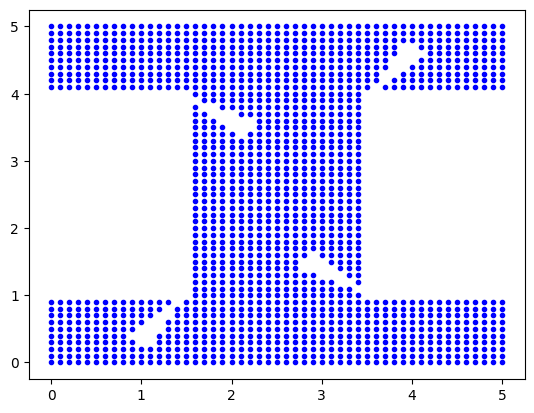

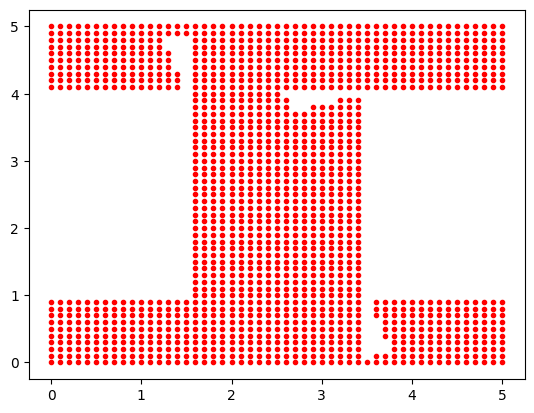

In [9]:
# Movement map maksing example
fig = plt.figure()
for i in range(len(X)):
    for j in range(len(Y)):
        if current_map['0'][i,j]:
            plt.plot(X[0,i], Y[j,0], '.b')

fig = plt.figure()
for i in range(len(X)):
    for j in range(len(Y)):
        if current_map['31'][i,j]:
            plt.plot(X[0,i], Y[j,0], '.r')
        

In [10]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

inflate_camera_view = 5
save_path = '~/ros2_ws/src/cognis_UAM/notebook/video/'

In [11]:
# Generate movement map animation
def anim_map(current_map):
    nk = len(current_map)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    
    def update(i):
        fig.clear()
        if i < nk:
            
            # Plot currently populated node
            currkey = str(i)
            for l in range(len(X)):
                for j in range(len(Y)):
                    if current_map[currkey][l,j]:
                        plt.plot(X[0,l], Y[j,0], '.b')
                        
            for b in range(nB):
                bcoor = building[b]
                plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
                plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
                plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
                plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')
                
            # Plot x0, xf
            plt.plot(x0[0], x0[1], 'or')
            plt.plot(xf[0], xf[1], 'ob')

            # Boxing the grid edge
            # Horizontal
            plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
            plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
            # Vertical
            plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
            plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

            # Plot Settings
            plt.grid()
            plt.axis('square')
            tol = 0.1
            plt.xlim(-tol, x[-1]+tol)
            plt.ylim(-tol, y[-1]+tol)
            plt.title("Timestep: {}".format(i))

    return matplotlib.animation.FuncAnimation(fig, update, frames=nk, interval=100)

# Save Animation into MP4
anim = anim_map(current_map)
anim.save('Movement_Map_Masking'+str(n_cam)+'Cam_Buliding_1.mp4', fps=5)
plt.close()

In [12]:
# Compute Cost Function
def costfunc(x0, x1):
    # How do we add restriction from camera FOV?
    s = np.sqrt((x0[0]-x1[0])**2 + (x0[1]-x1[1])**2)# + np.sqrt((x0[0]-xf[0])**2 + (x0[1]-xf[1])**2)**2
    return s

In [13]:
# Check if following position is within valid movement map_k at time tk
def check_map(i_x, current_map_k):
    return bool(current_map_k[i_x[0], i_x[1]])

/tmp/ipykernel_10498/316041592.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Length V_data: 63
61


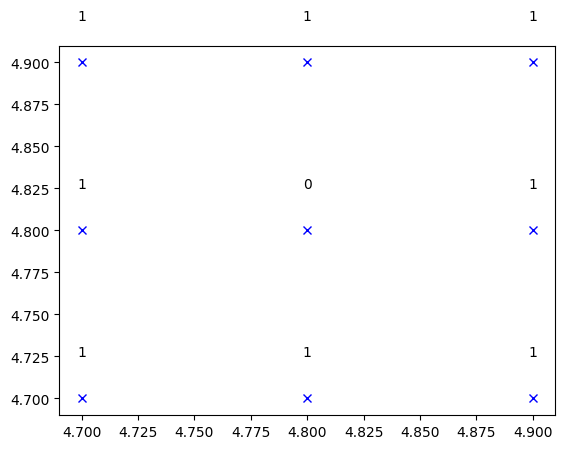

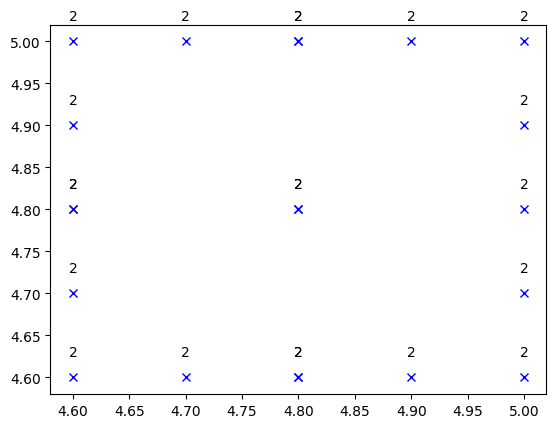

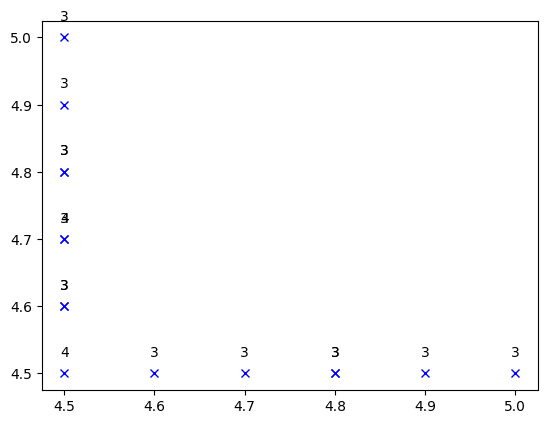

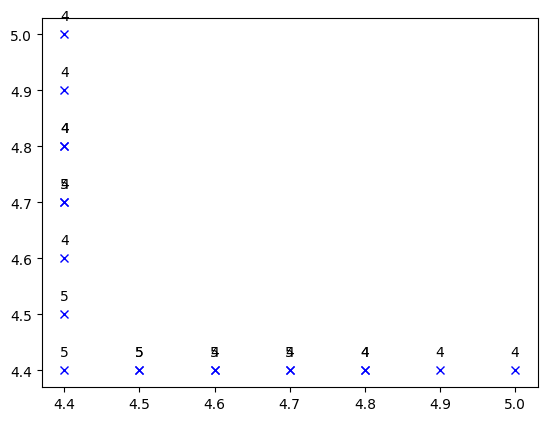

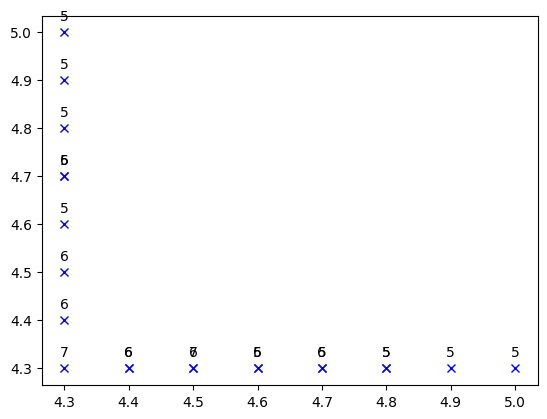

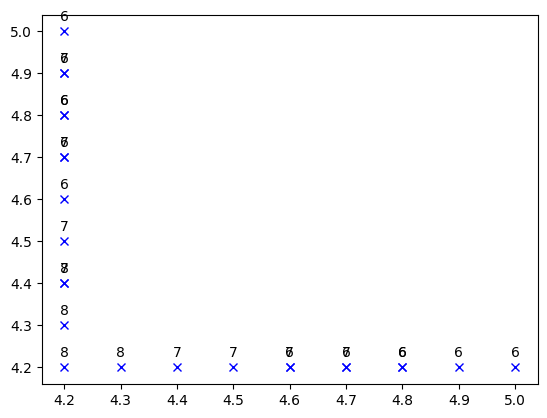

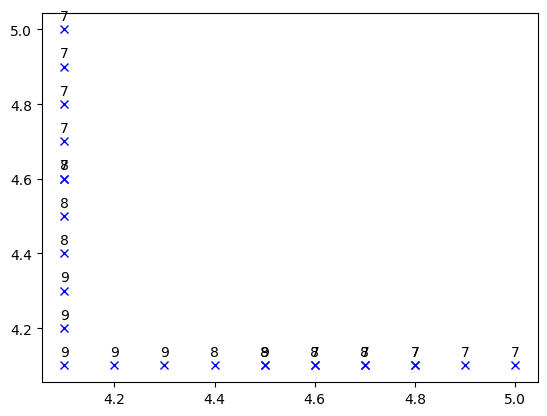

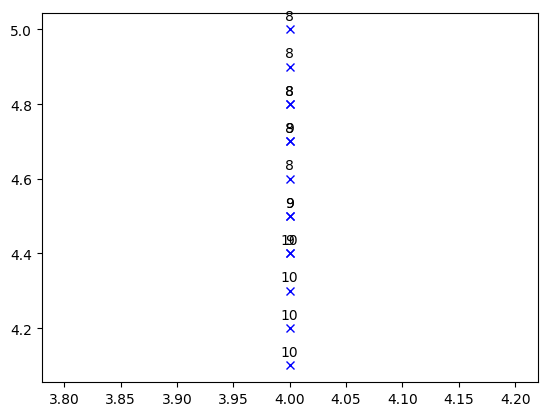

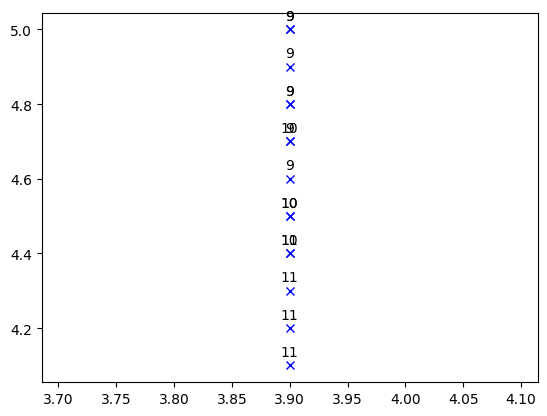

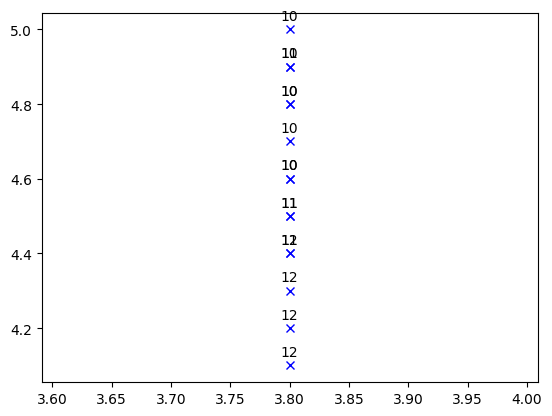

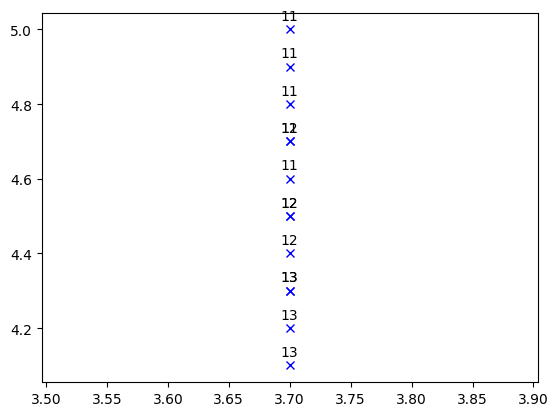

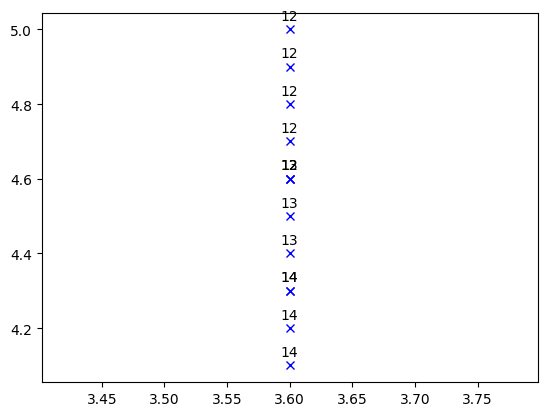

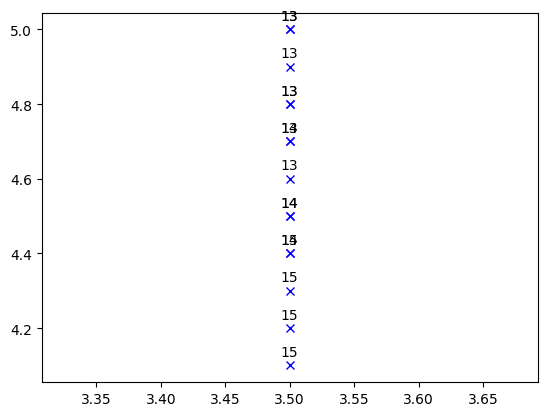

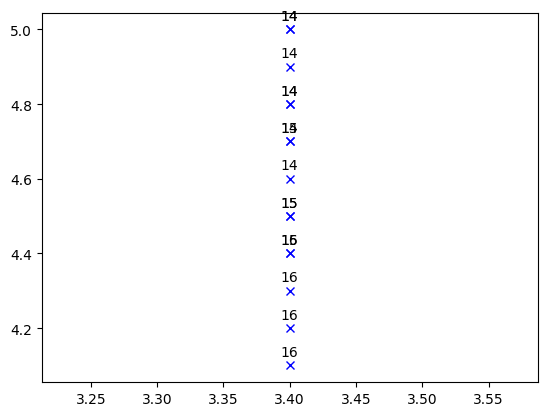

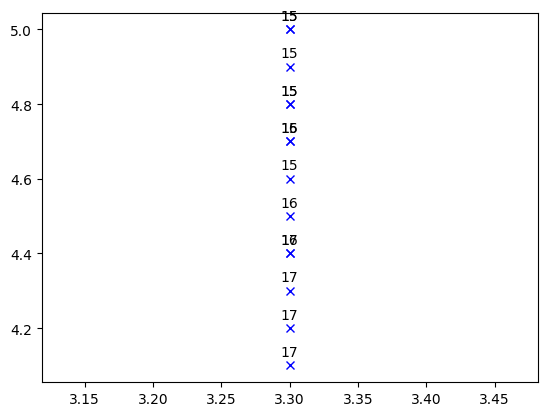

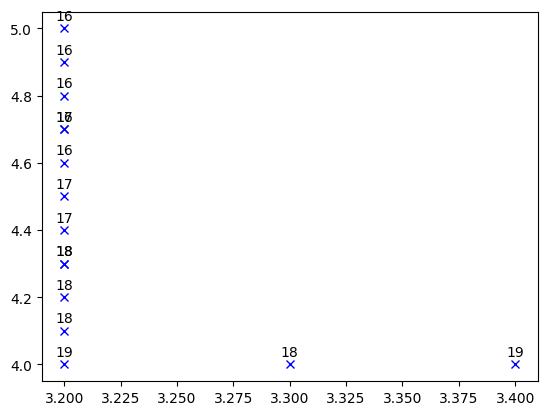

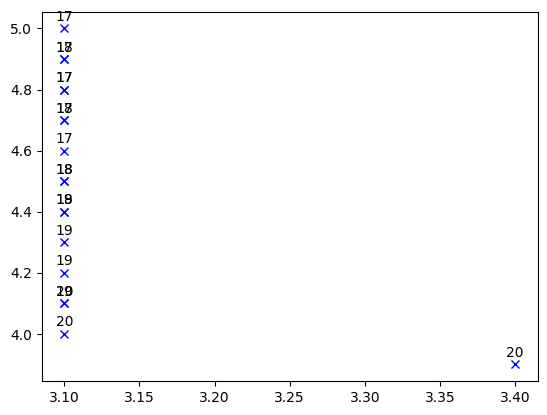

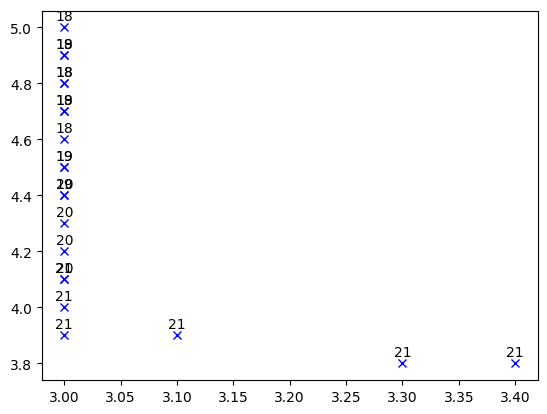

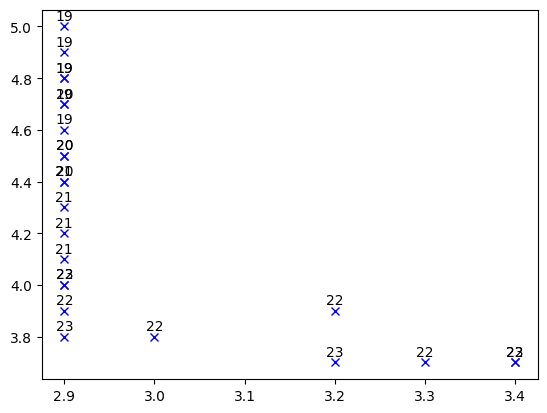

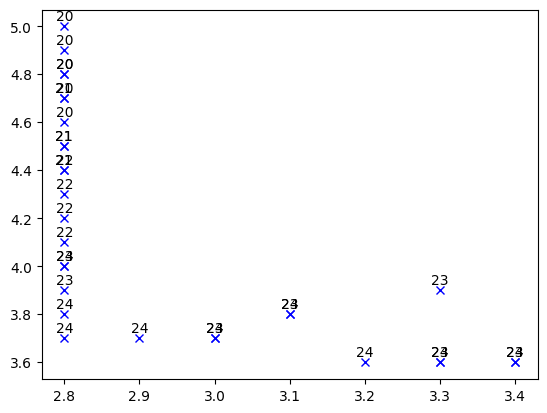

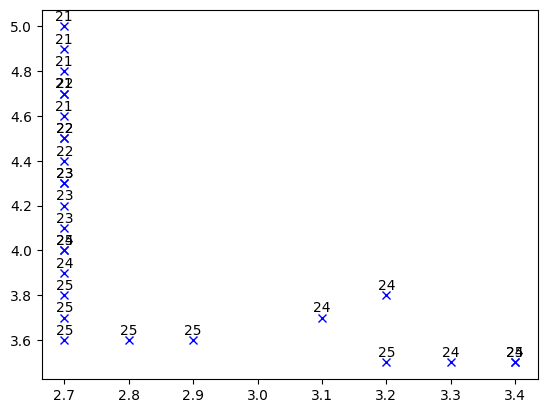

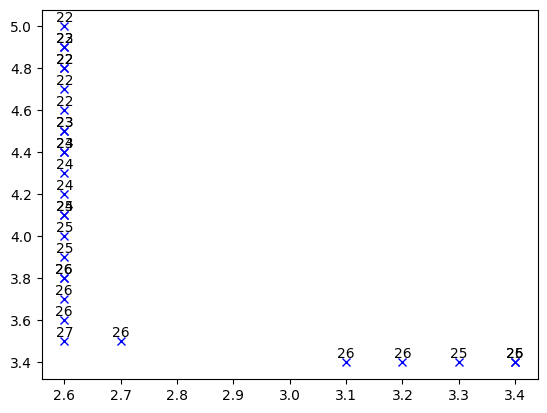

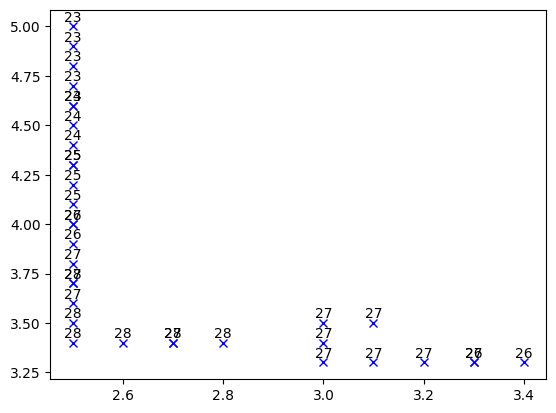

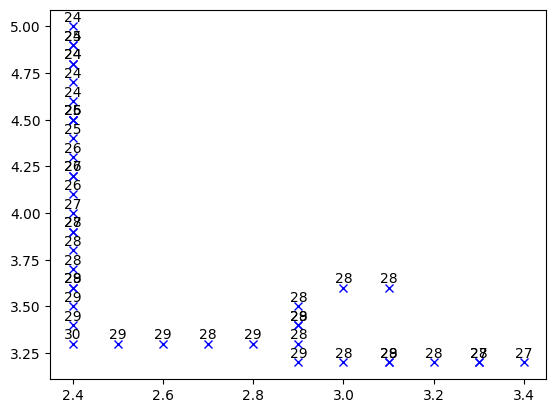

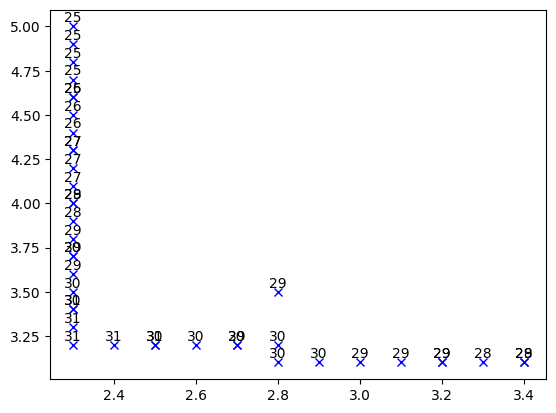

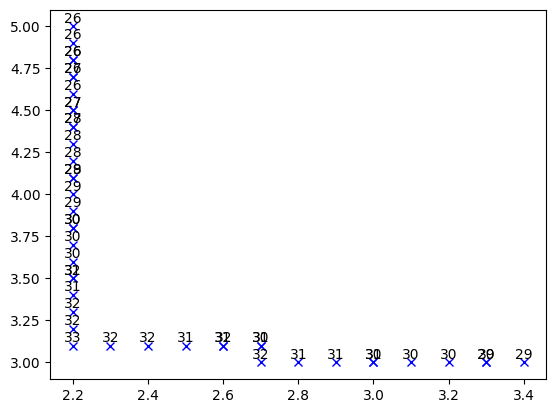

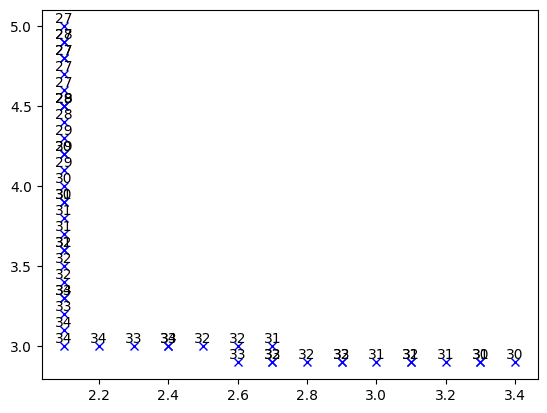

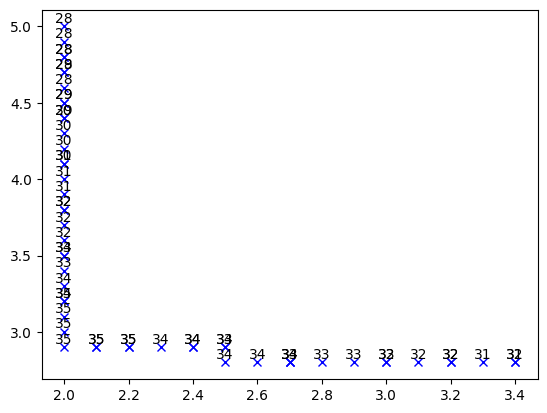

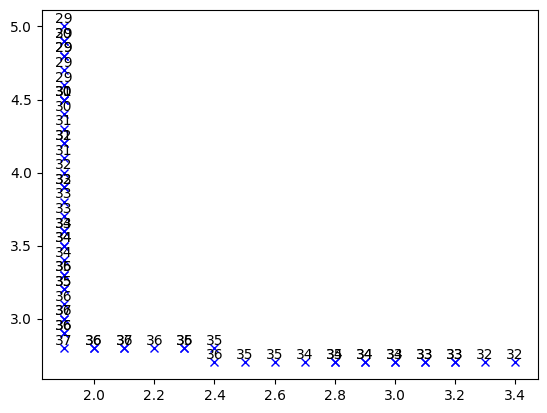

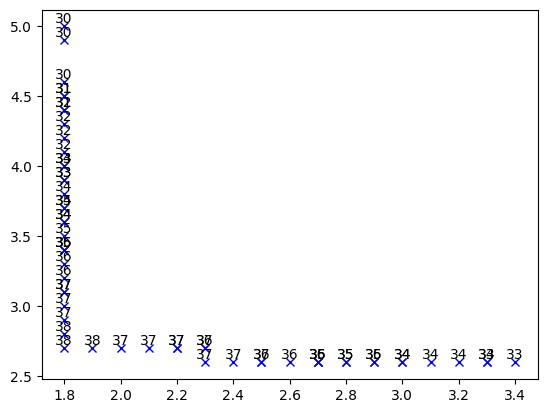

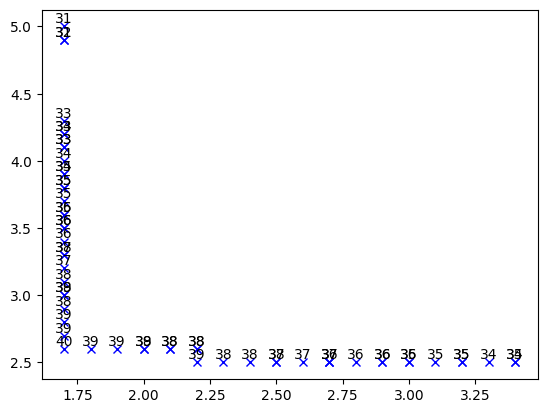

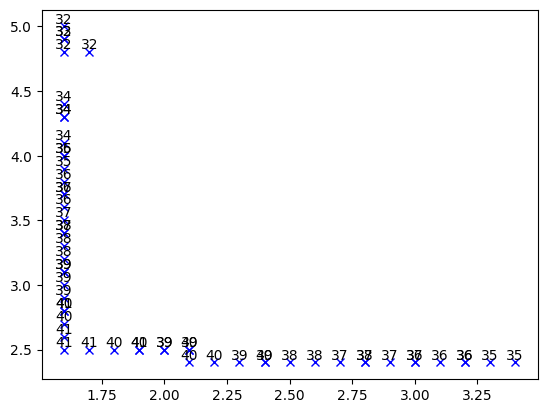

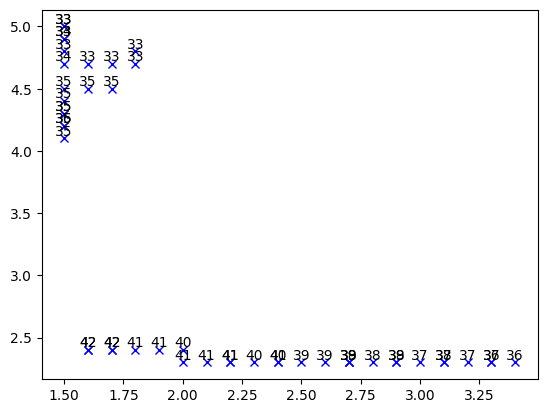

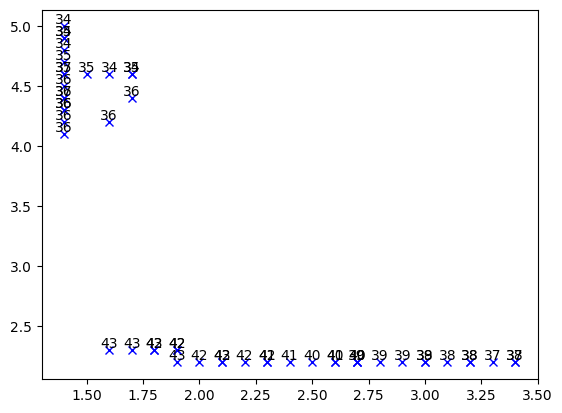

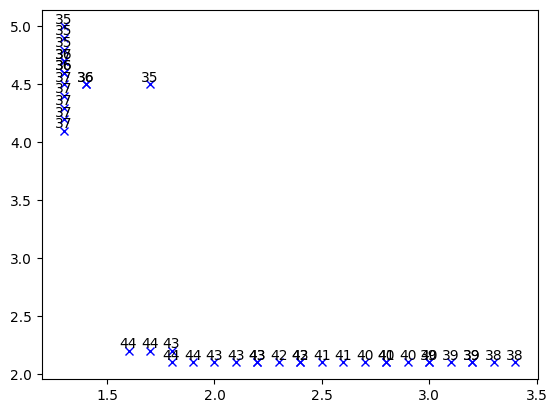

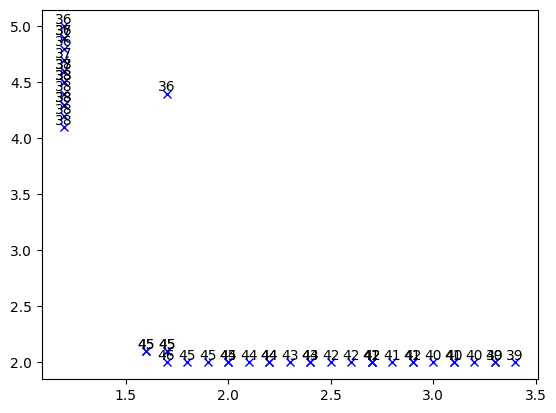

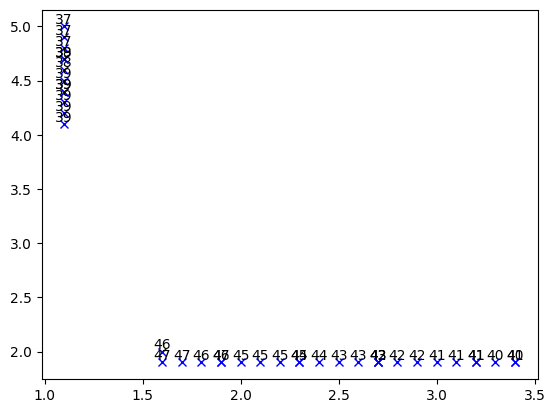

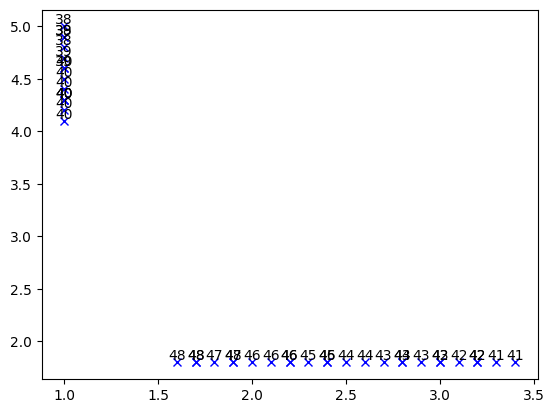

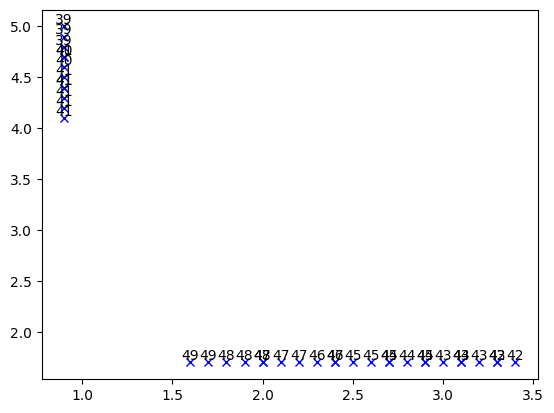

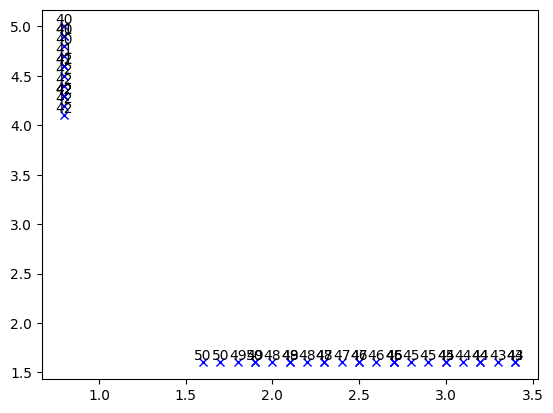

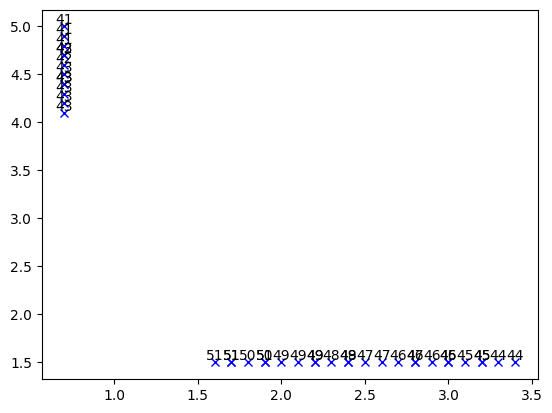

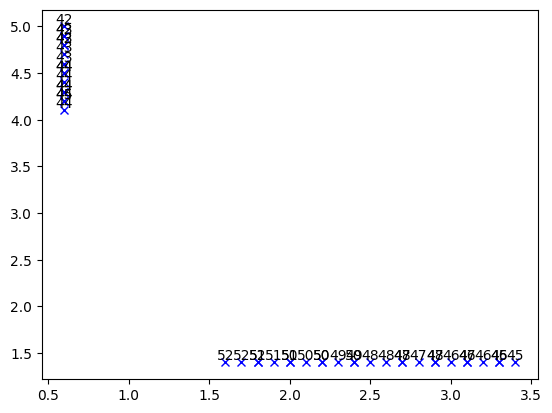

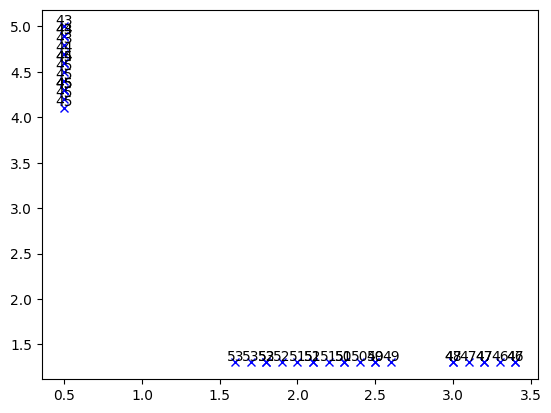

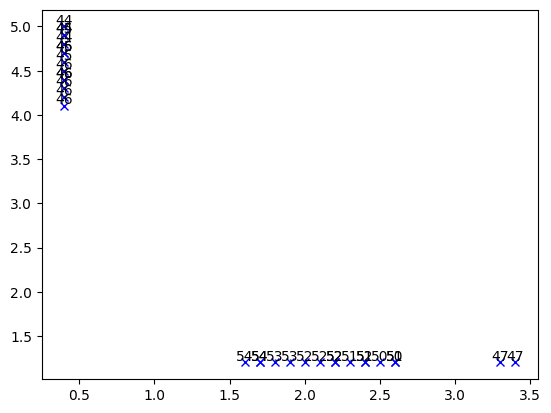

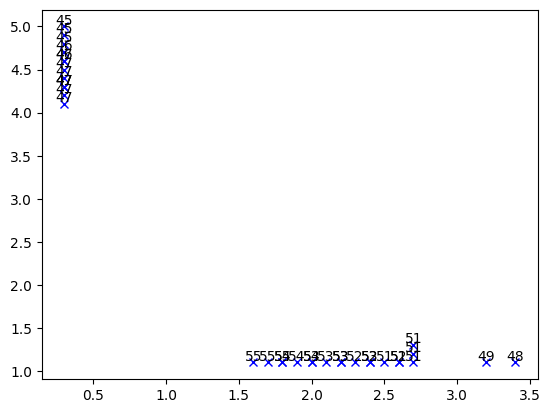

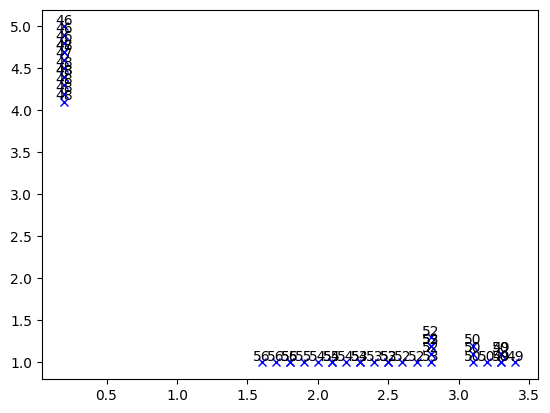

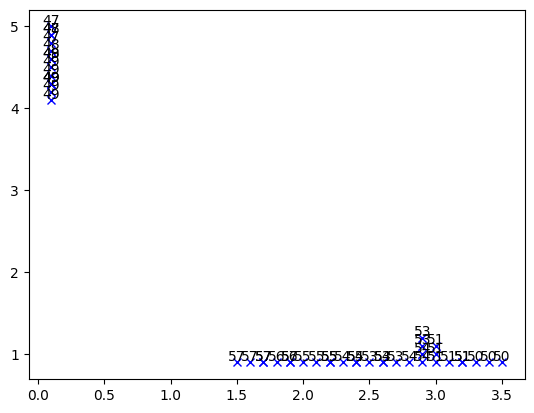

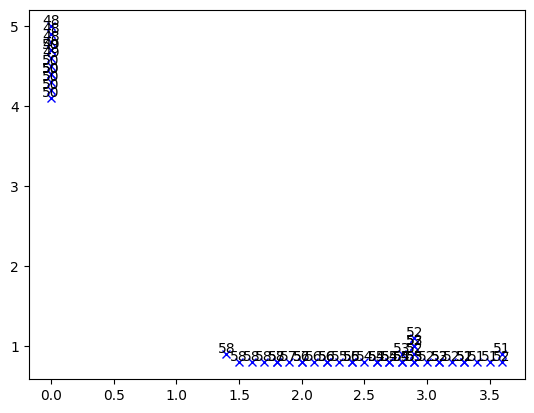

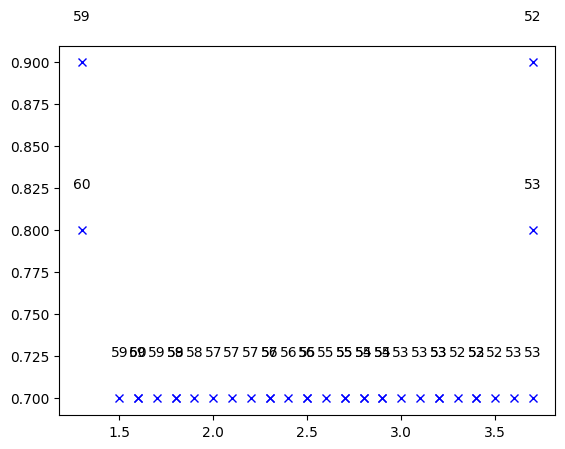

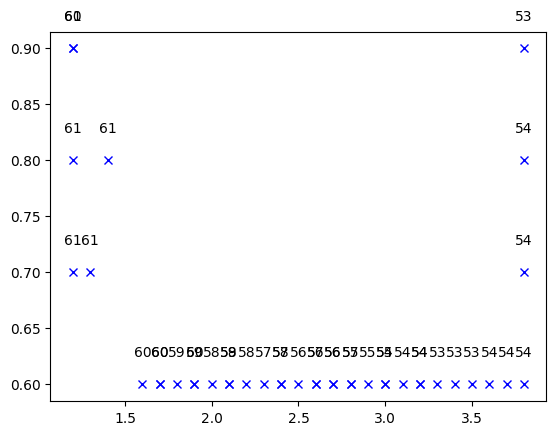

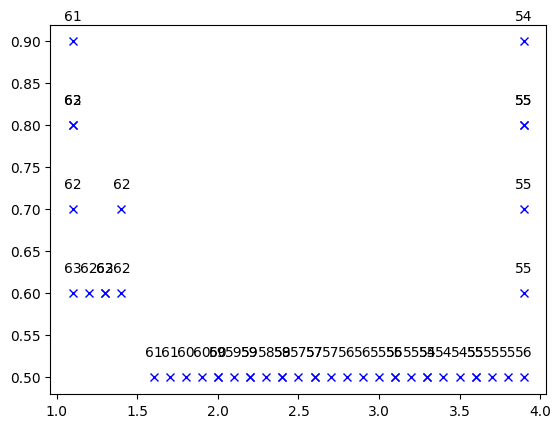

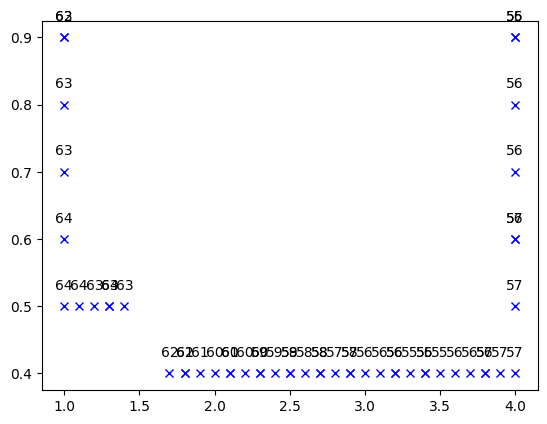

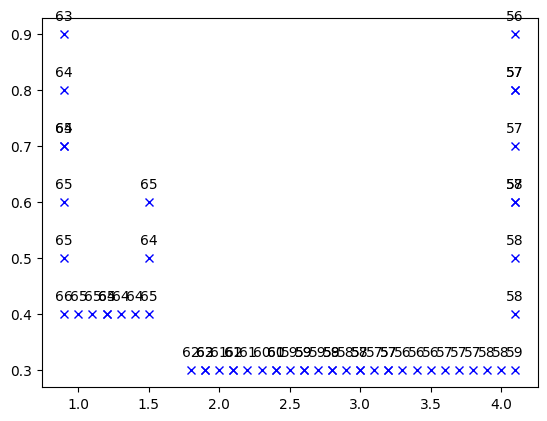

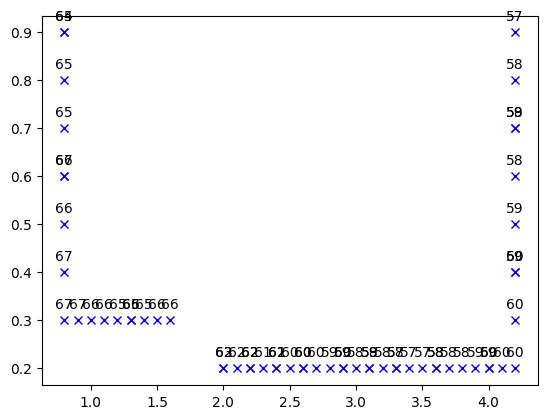

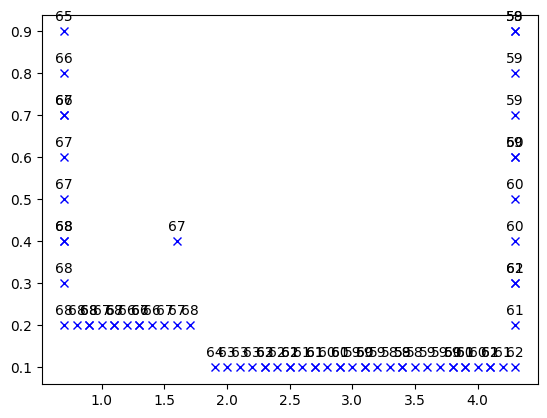

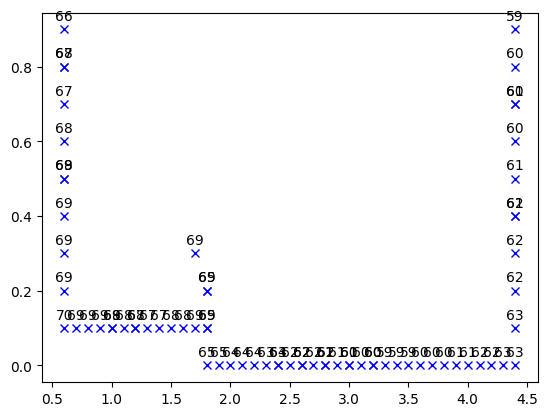

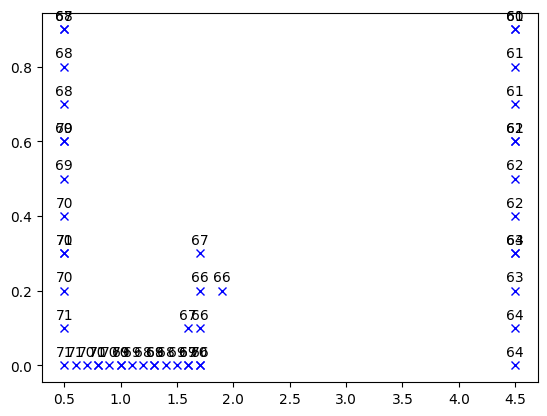

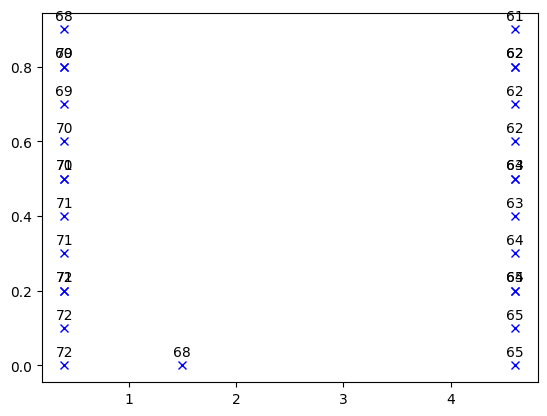

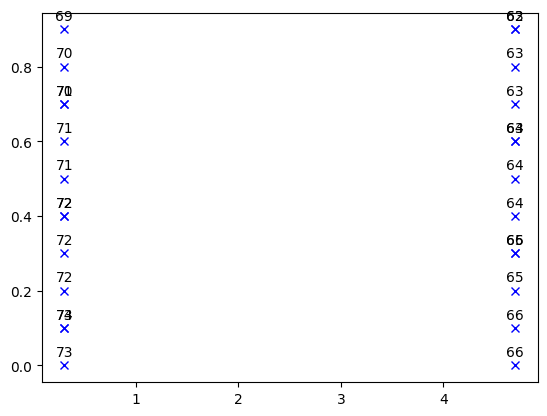

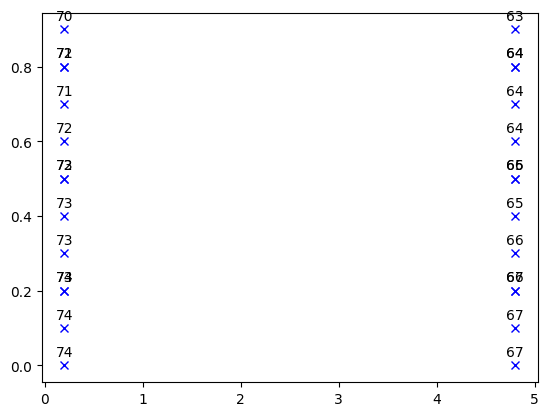

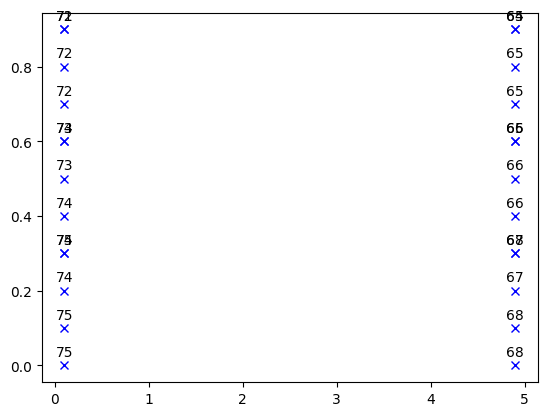

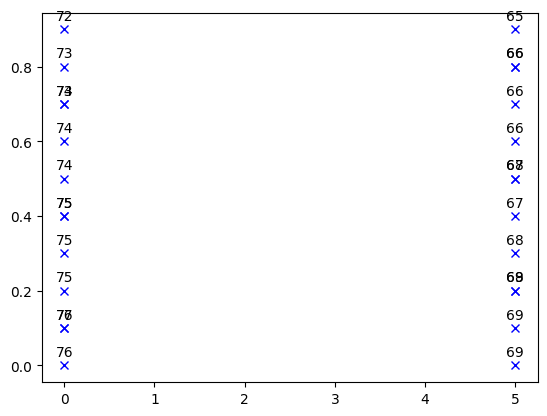

<Figure size 640x480 with 0 Axes>

In [14]:
import copy

# Initialize Final Point
i_x_prev = i_xf
i_x = i_x_prev
V = np.zeros((n, n))
live = [[i_x[0], i_x[1]]]
live_hist = {}
live_hist['0'] = live

commentTrigger = False

# Possible Actions
movement = [
    (1, 0), (-1, 0),  # Horizontal
    (0, 1), (0, -1),  # Vertical
    (0, 0)           # Stationary
    , (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]

# Compute moves from current node
V_data = []
time_fin = None
counter = 0
kek = end_in
while len(live) > 0:
    fig = plt.figure()
    new = set()
    # Bound iteration between camvec
    end_in_prev = kek
    for j in range(n_cam):
        if end_in_prev[j] > len(camvec[j]):
            end_in_prev[j] = end_in_prev[j] - len(camvec[j])
        elif end_in_prev[j] < 0:
            end_in_prev[j] = end_in_prev[j] + len(camvec[j])
    # Populate Node for cost function
    
    for p in live:
        for a in movement:
            # Obtain next movement pa
            pa = (p[0] - a[0], p[1] - a[1])
            
            # If our next move (pa) in current map in tk is valid,
            currkey = str(end_in_prev[0])
            if bound(pa) and check_map(pa, current_map[currkey]):      
                #If pa is out of all camera bound
                if pa == i_x0:
                    time_fin = counter
                V_new = costfunc(p, pa) + V[p[0], p[1]]                
                V_old = V[pa[0], pa[1]]
                if V_old == 0 or V_new < V_old:
                    V[pa[0], pa[1]] = V_new
                    new.add((pa[0], pa[1]))
                    temp = position(pa)
                    plt.plot(temp[0], temp[1], 'xb')
                    plt.text(temp[0], temp[1]+0.025, "%d" %V_new, ha="center")
    live = new
    key = str(counter)
    live_hist[key] = live
    V_data.append(copy.copy(V))
    kek = end_in_prev - 1
    counter += 1

for i in range(len(V_data)):
    V[i_xf[0], i_xf[1]] = 0
    V_data[i][i_xf[0], i_xf[1]] = 0
    
print("Length V_data: {}".format(len(V_data)))
print(time_fin)

In [15]:
print(V[i_xf[0], i_xf[1]])
print(V_data[-1][i_xf[0], i_xf[1]])

0.0
0.0


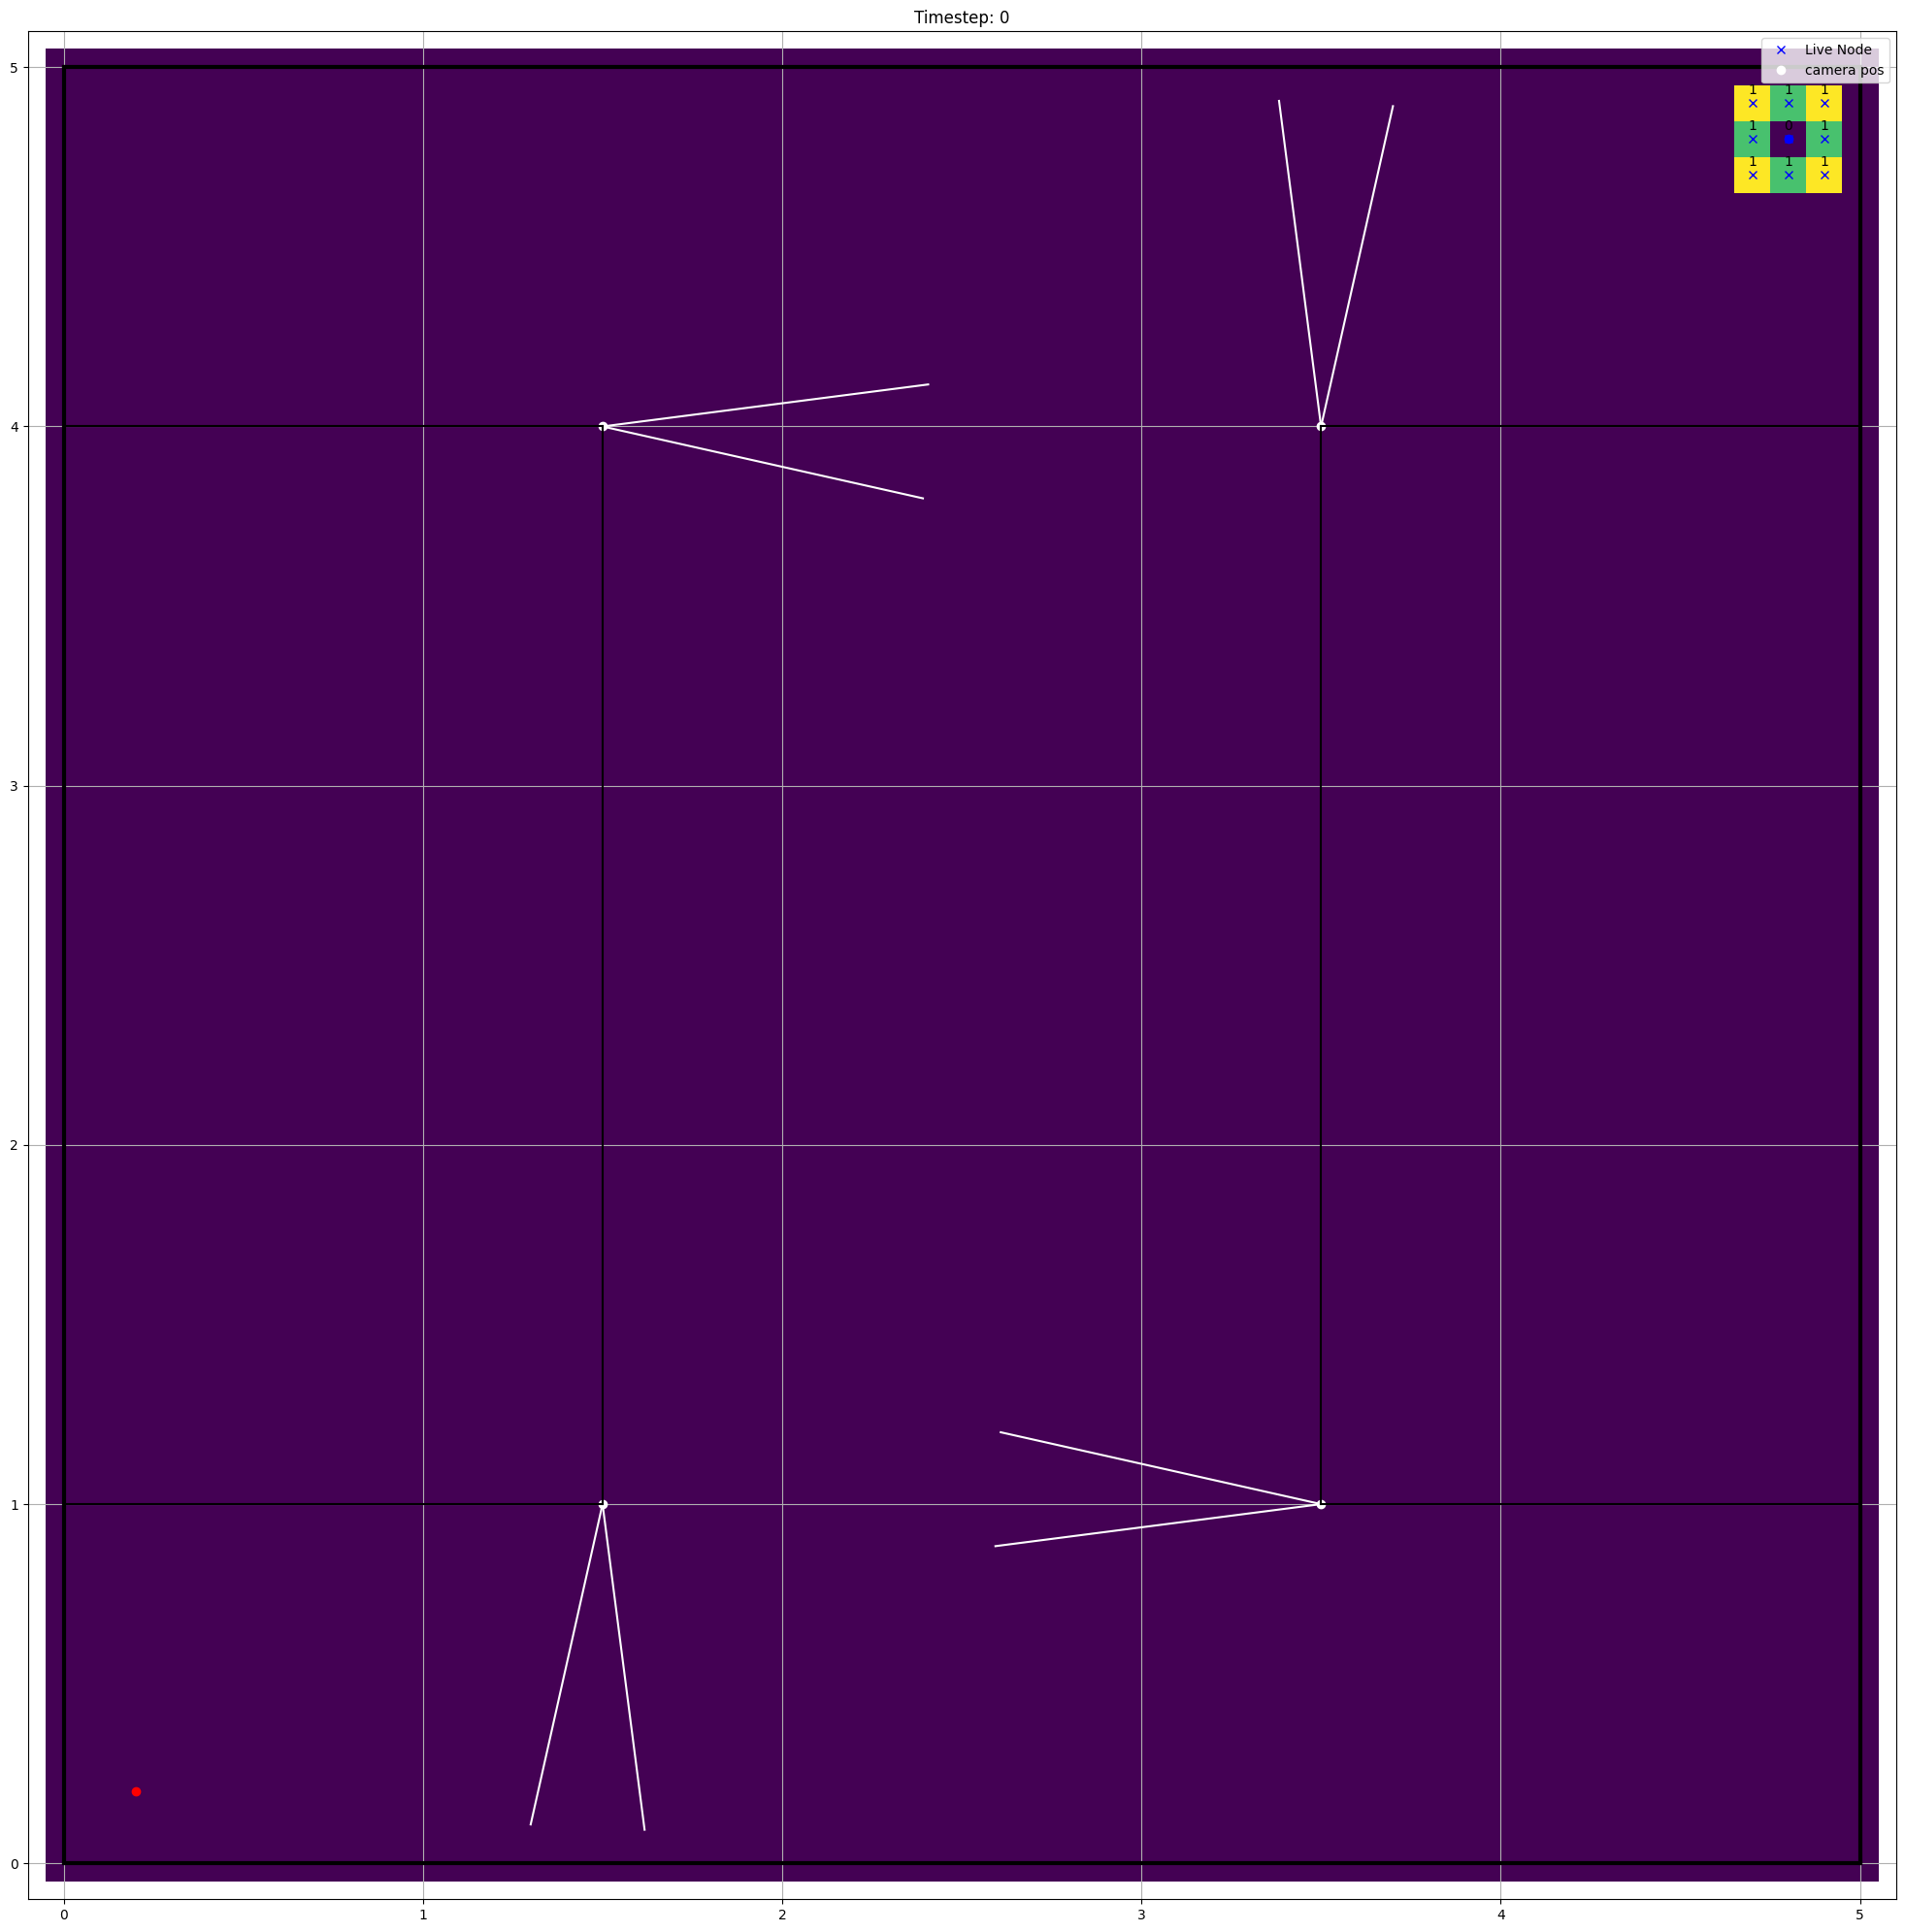

In [16]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())   
    
    def update(i):
        fig.clear()
        if i < nV:
            # Grid Coloring
            plt.pcolor(X, Y, V_data[i].T, vmin=V_data[i].min(), vmax=V_data[i].max())
            
            # Node Population
            # Find current index from dictionary and plot populated node
            curr_key = str(i)
            liveNode = live_hist[curr_key]
            primaris = 0
            for p in liveNode:
                cawl = position(p)
                plt.plot(cawl[0], cawl[1], 'xb', label='Live Node' if primaris == 0 else "")
                val = V_data[i][p[0], p[1]]
                plt.text(cawl[0], cawl[1]+0.025, "%d" %val, ha="center")
                primaris += 1
            
            # Camera Visualization
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'ow', label='camera pos' if ind == 0 else "")

                # Plot Camera FOV
                k = end_in[ind]-i%len(tvec[ind])
                if k < 0:
                    k = k + len(tvec[ind])-1
                elif k > len(tvec[ind]):
                    k = k - len(tvec[ind])-1
                theta = camvec[ind, k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)
                #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-w')
                plt.plot(xprime2, yprime2, '-w')

            for b in range(nB):
                bcoor = building[b]
                plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
                plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
                plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
                plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')
                
            # Plot x0, xf
            plt.plot(x0[0], x0[1], 'or')
            plt.plot(xf[0], xf[1], 'ob')

            # Boxing the grid edge
            # Horizontal
            plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
            plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
            # Vertical
            plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
            plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

            # Plot Settings
            plt.grid()
            plt.axis('square')
            tol = 0.1
            plt.xlim(-tol, x[-1]+tol)
            plt.ylim(-tol, y[-1]+tol)
            plt.legend(loc="upper right")
            plt.title("Timestep: {}".format(i))

    return matplotlib.animation.FuncAnimation(fig, update, frames=nV, interval=100)

# Save Animation into MP4
anim = anim_dyn_prog(V_data)
anim.save('Vdata_Propagation_'+str(n_cam)+'Cam_Buliding_1.mp4', fps=5)

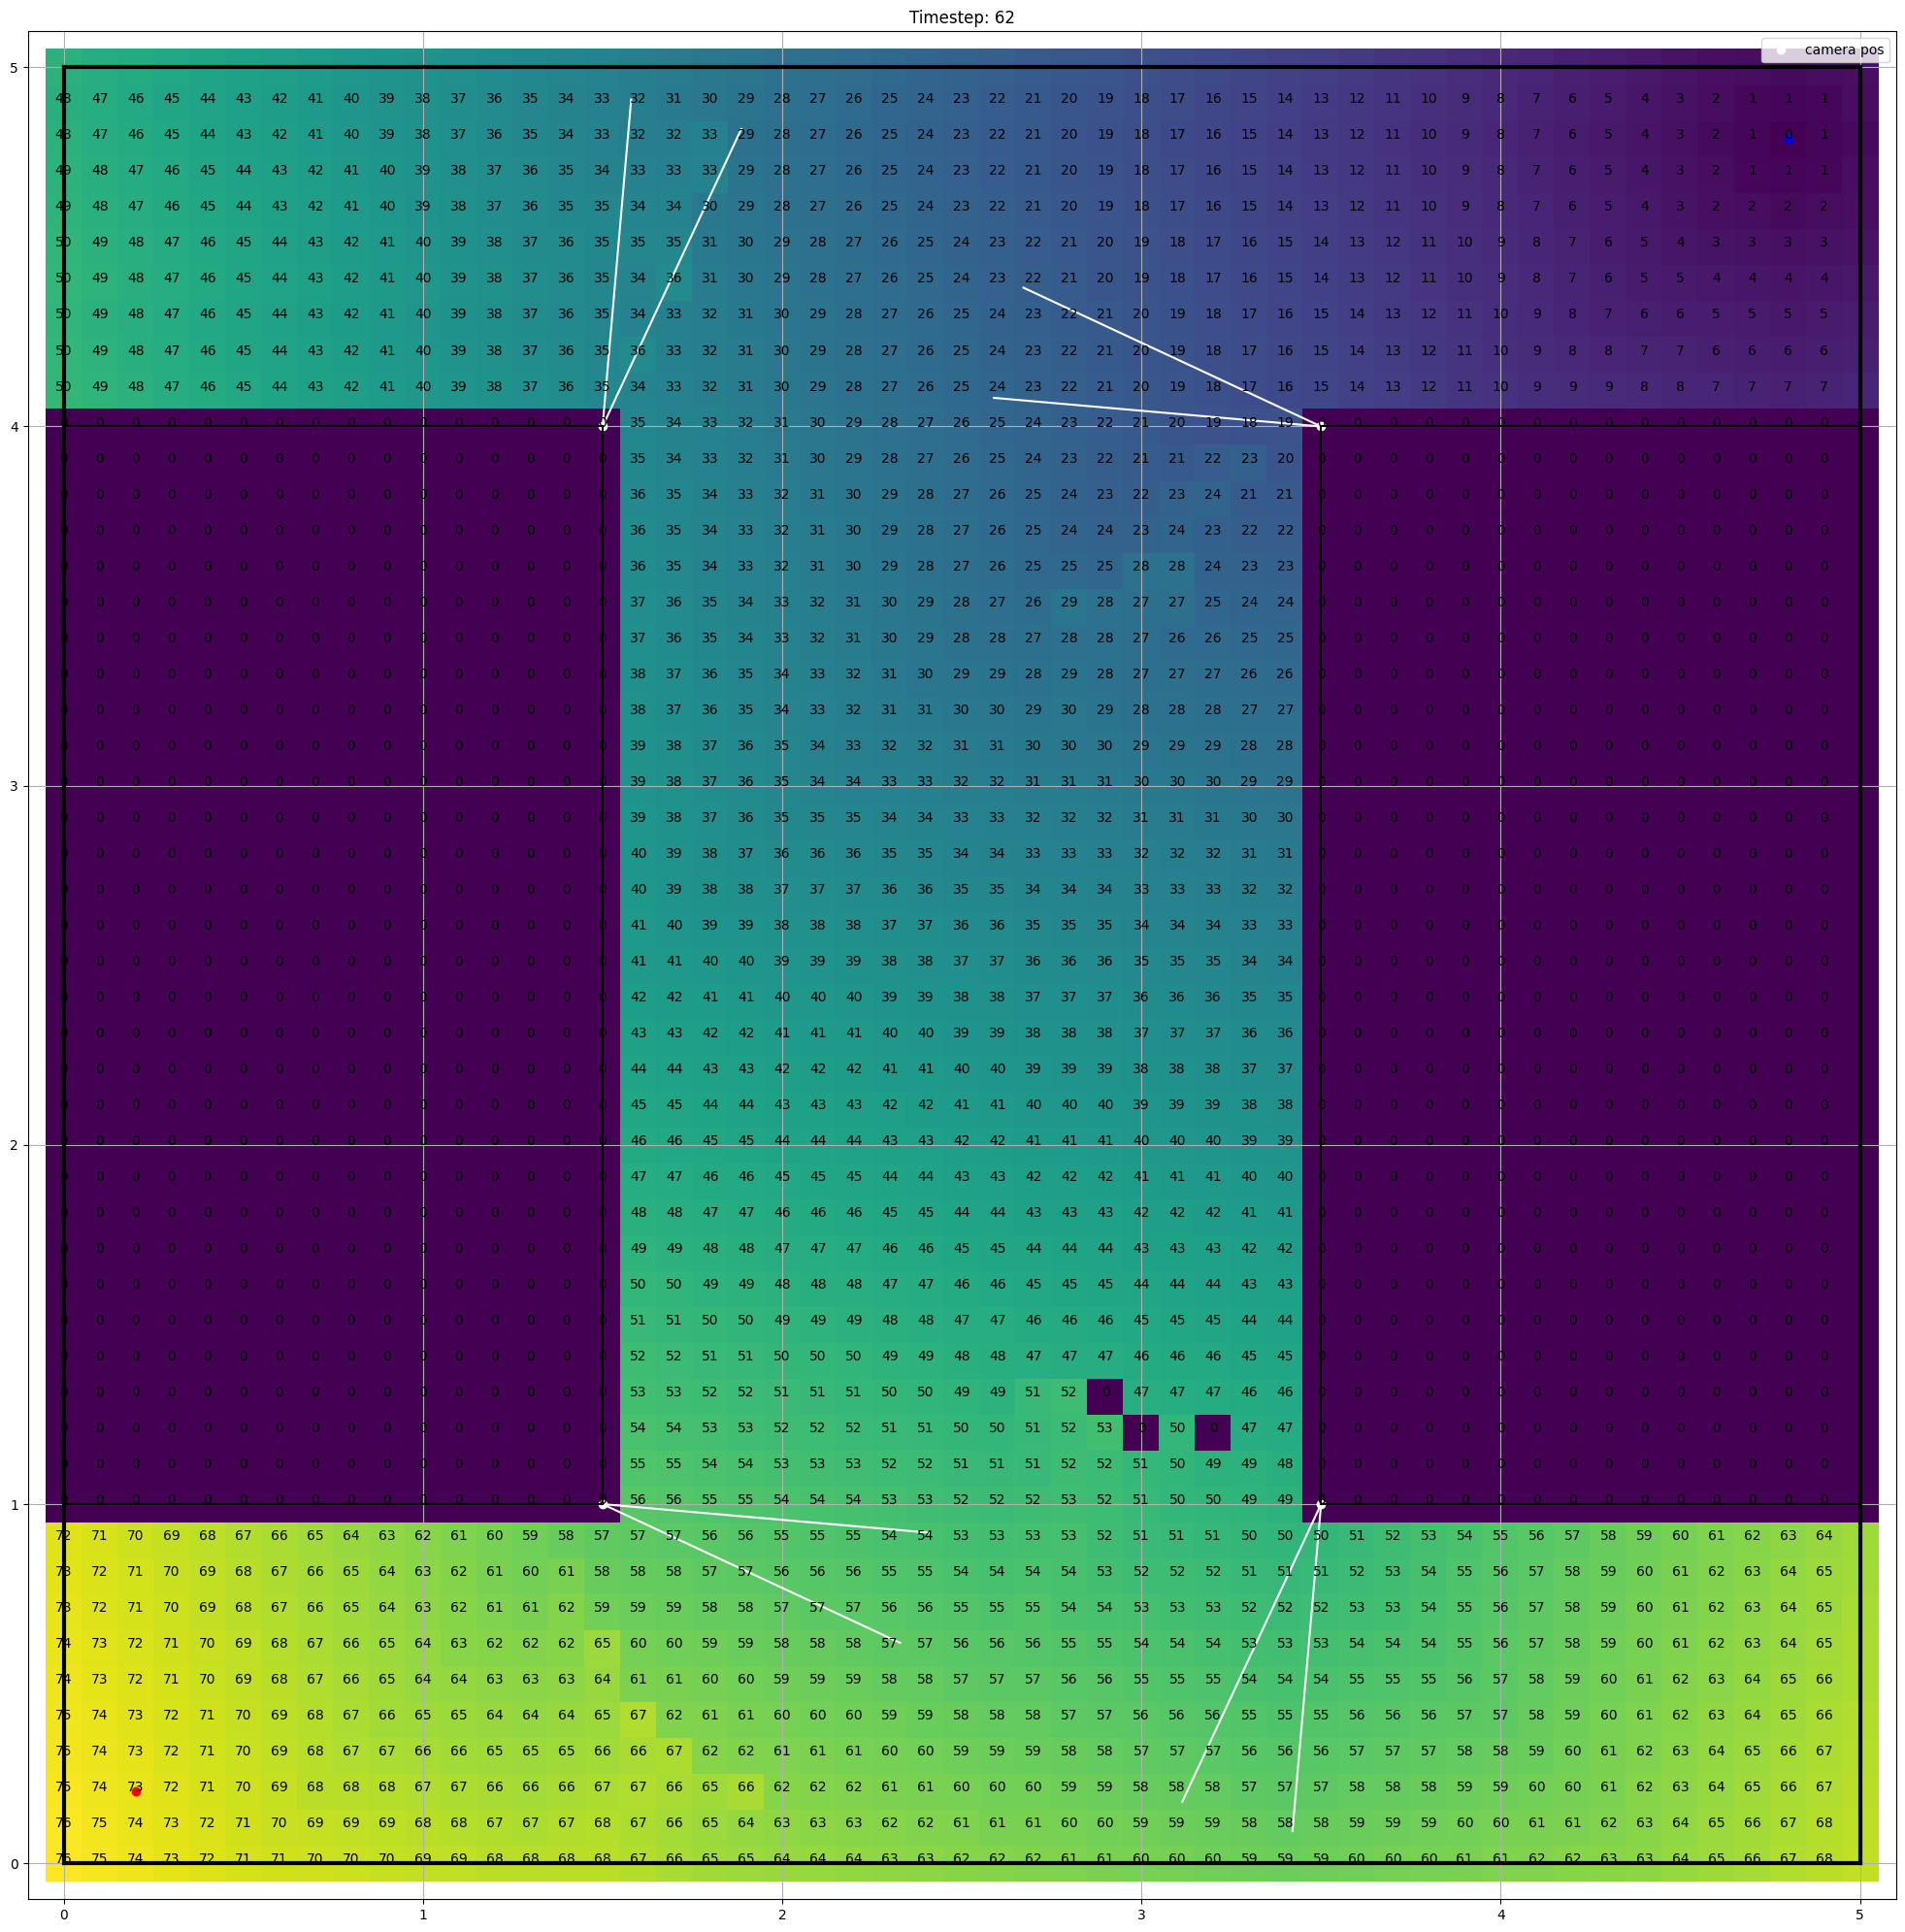

In [17]:
nV = len(V_data)
fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())   

i = nV-1

# Grid Coloring
plt.pcolor(X, Y, V_data[i].T, vmin=V_data[i].min(), vmax=V_data[i].max())

# Node Population
# Find current index from dictionary and plot populated node
curr_key = str(i)
liveNode = live_hist[curr_key]
primaris = 0
for p in liveNode:
    cawl = position(p)
    plt.plot(cawl[0], cawl[1], 'xb', label='Live Node' if primaris == 0 else "")
    val = V_data[i][p[0], p[1]]
    #plt.text(cawl[0], cawl[1]+0.025, "%d" %val, ha="center")
    primaris += 1

for m in range(len(X)-1):
    for n in range(len(Y)-1):
        val = V_data[i][m, n]
        titan = position((m,n))
        plt.text(titan[0], titan[1], "%d" %val, ha="center")

# Camera Visualization
for ind in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[ind,0], campos[ind,1], 'ow', label='camera pos' if ind == 0 else "")

    # Plot Camera FOV
    k = end_in[ind]-i%len(tvec[ind])
    if k < 0:
        k = k + len(tvec[ind])-1
    elif k > len(tvec[ind]):
        k = k - len(tvec[ind])-1
    theta = camvec[ind, k]
    xend = campos[ind,0]+fov_rng*np.cos(theta)
    yend = campos[ind,1]+fov_rng*np.sin(theta)
    #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

    # FOV LOS
    h = fov_rng*np.tan(fov_ang/2)
    Rprime = np.sqrt(h**2 + fov_rng**2)

    xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
    yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
    xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
    yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
    plt.plot(xprime1, yprime1, '-w')
    plt.plot(xprime2, yprime2, '-w')

for b in range(nB):
    bcoor = building[b]
    plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
    plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
    plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
    plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')

# Plot x0, xf
plt.plot(x0[0], x0[1], 'or')
plt.plot(xf[0], xf[1], 'ob')

# Boxing the grid edge
# Horizontal
plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
# Vertical
plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

# Plot Settings
plt.grid()
plt.axis('square')
tol = 0.1
plt.xlim(-tol, x[-1]+tol)
plt.ylim(-tol, y[-1]+tol)
plt.legend(loc="upper right")
plt.title("Timestep: {}".format(i))
plt.show()

In [18]:
# Sanity Check
SanityCheck = type(None)

# Comment Trigger
commentTrigger = False

p_hist_opt_k = {}
pos_hist_opt_k = {}

# Compute Optimal Path for teach time vector start
# Then we match final FOV to find out which time tk start grants camera final state at tf

for tk in range(len(tvec.T)):
    p = i_x0
    p_hist_opt = [p]
    count = 0
    while p != i_xf:
        # Find current time to check where the camera angle is:
        curr_time = (tk+count)%len(camvec.T)
        next_time = curr_time + 1
        if next_time >= len(camvec.T):
            next_time = next_time-len(camvec[0])

        # Populate Node for cost function
        V_opt = None
        Vcheck = []
        pa_list = []

        for a in movement:
            pa = (p[0] + a[0], p[1] + a[1])
            # Check Camera State
            # If our next move (pa) in current map in tk is valid,
            nextkey = str(next_time)
            if bound(pa) and check_map(pa, current_map[nextkey]):               
                #If pa is out of all camera bound
                V_new = V[pa[0], pa[1]]
                pa_list.append(pa)
                Vcheck.append(V_new)
        if len(Vcheck) == 0:
            break
        min_val = Vcheck.index(min(Vcheck))
        V_opt = Vcheck[min_val]
        pa_opt = pa_list[min_val]

        for a in movement:
            if bound(pa) and check_map(pa, current_map[currkey]):
                if pa == i_xf: break

        # Exit loop if this is not going anywhere
        if count > 100: break
        p = pa_opt
        
        # Check if p is empty
        # If p is empty: There is no solution exist s.t. x0 and xf can be connected without detection
        if isinstance(p, SanityCheck):
            break
        else:
            p_hist_opt.append(p)
            count += 1

    # Obtain position history of tk start
    pos_hist_opt = np.array([position(p) for p in p_hist_opt])
    #print(len(pos_hist_opt))
    
    # Save histories to dictionary with key tk
    currt_key = str(tk)
    p_hist_opt_k[currt_key] = p_hist_opt
    pos_hist_opt_k[currt_key] = pos_hist_opt
    
# Find position history with matching camera state at tf
tf_vec = []
for k in range(len(pos_hist_opt_k)):
    # k is a start time
    # If we add length of time taken to reach xf and take modular value, we get tf
    tf_k = (k + len(pos_hist_opt_k[str(k)]))%len(camvec.T)
    
    # Check if obtained tf_k is same as our set tf
    if tf_k == end_in[0]:
        tf_vec.append(tf_k)



In [19]:
print(tf_vec)
p_hist_opt = p_hist_opt_k[str(int(tf_vec[0]))]
pos_hist_opt = pos_hist_opt_k[str(int(tf_vec[0]))]

[45]


In [20]:
# Find FOV time vectors
end_index = end_in
nP = len(pos_hist_opt)
FOVtvec = np.zeros((nP,4))
FOVtvec_rev = np.zeros((nP,4))


for k in range(len(end_in)):
    for i in range(nP):
        curr_FOVtvec = end_index[k] - i
        if curr_FOVtvec < 0:
            curr_FOVtvec = curr_FOVtvec + len(tvec[0]) - 1
        
        FOVtvec[nP-i-1,k] = int(curr_FOVtvec)
        FOVtvec_rev[i,k] = int(curr_FOVtvec)

In [21]:
def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
    plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    
    def update(i):
        fig.clear()
        if i < nP:
            # Current FOV tvec
            currFOVtvec = FOVtvec[i,:]
            
            # Plot from t0
            plt.pcolor(X, Y, V_data[nV-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())

            # Plot Time Varying FOV
            plt.plot(pos_hist_opt[:i,0], pos_hist_opt[:i,1], '--k', label = 'Aggressor Position History')
            plt.plot(pos_hist_opt[i-1:i+1,0], pos_hist_opt[i-1:i+1,1], '-k')
            plt.plot(pos_hist_opt[i,0], pos_hist_opt[i,1], 'ok', label = 'Aggressor')
            for ind in range(n_cam):
                # Plot Camera Position
                plt.plot(campos[ind,0], campos[ind,1], 'ow', label = 'Camera Position' if ind == 0 else "")

                # Plot Camera FOV
                k = int(currFOVtvec[ind])
                theta = camvec[ind,k]
                xend = campos[ind,0]+fov_rng*np.cos(theta)
                yend = campos[ind,1]+fov_rng*np.sin(theta)

                # FOV LOS
                h = fov_rng*np.tan(fov_ang/2)
                Rprime = np.sqrt(h**2 + fov_rng**2)

                xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2)]
                yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2)]
                xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
                yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
                xprime3 = [campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2), campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
                yprime3 = [campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2), campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
                plt.plot(xprime1, yprime1, '-w')
                plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV' if ind == 0 else "")
                plt.plot(xprime3, yprime3, '-w')
                         
        # Timer Indication
        plt.title('Timestep: {}'.format(i))

        # Plot x0, xf
        plt.plot(x0[0], x0[1], 'or', label = 'Initial Point')
        plt.plot(xf[0], xf[1], 'ob', label = 'Final Point')

        # Boxing the grid edge
        # Horizontal
        plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
        plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
        # Vertical
        plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
        plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

        for m in range(len(X)-1):
            for n in range(len(Y)-1):
                val = V_data[-1][m, n]
                titan = position((m,n))
                plt.text(titan[0], titan[1], "%d" %val, ha="center")
        
        # Plot Settings
        #plt.grid()
        plt.axis('square')
        tol = 0.1
        plt.xlim(-tol, x[-1]+tol)
        plt.ylim(-tol, y[-1]+tol)
        plt.legend(loc="right", fontsize = 20)

    return matplotlib.animation.FuncAnimation(fig, update, frames=nP, interval=50, repeat=False)

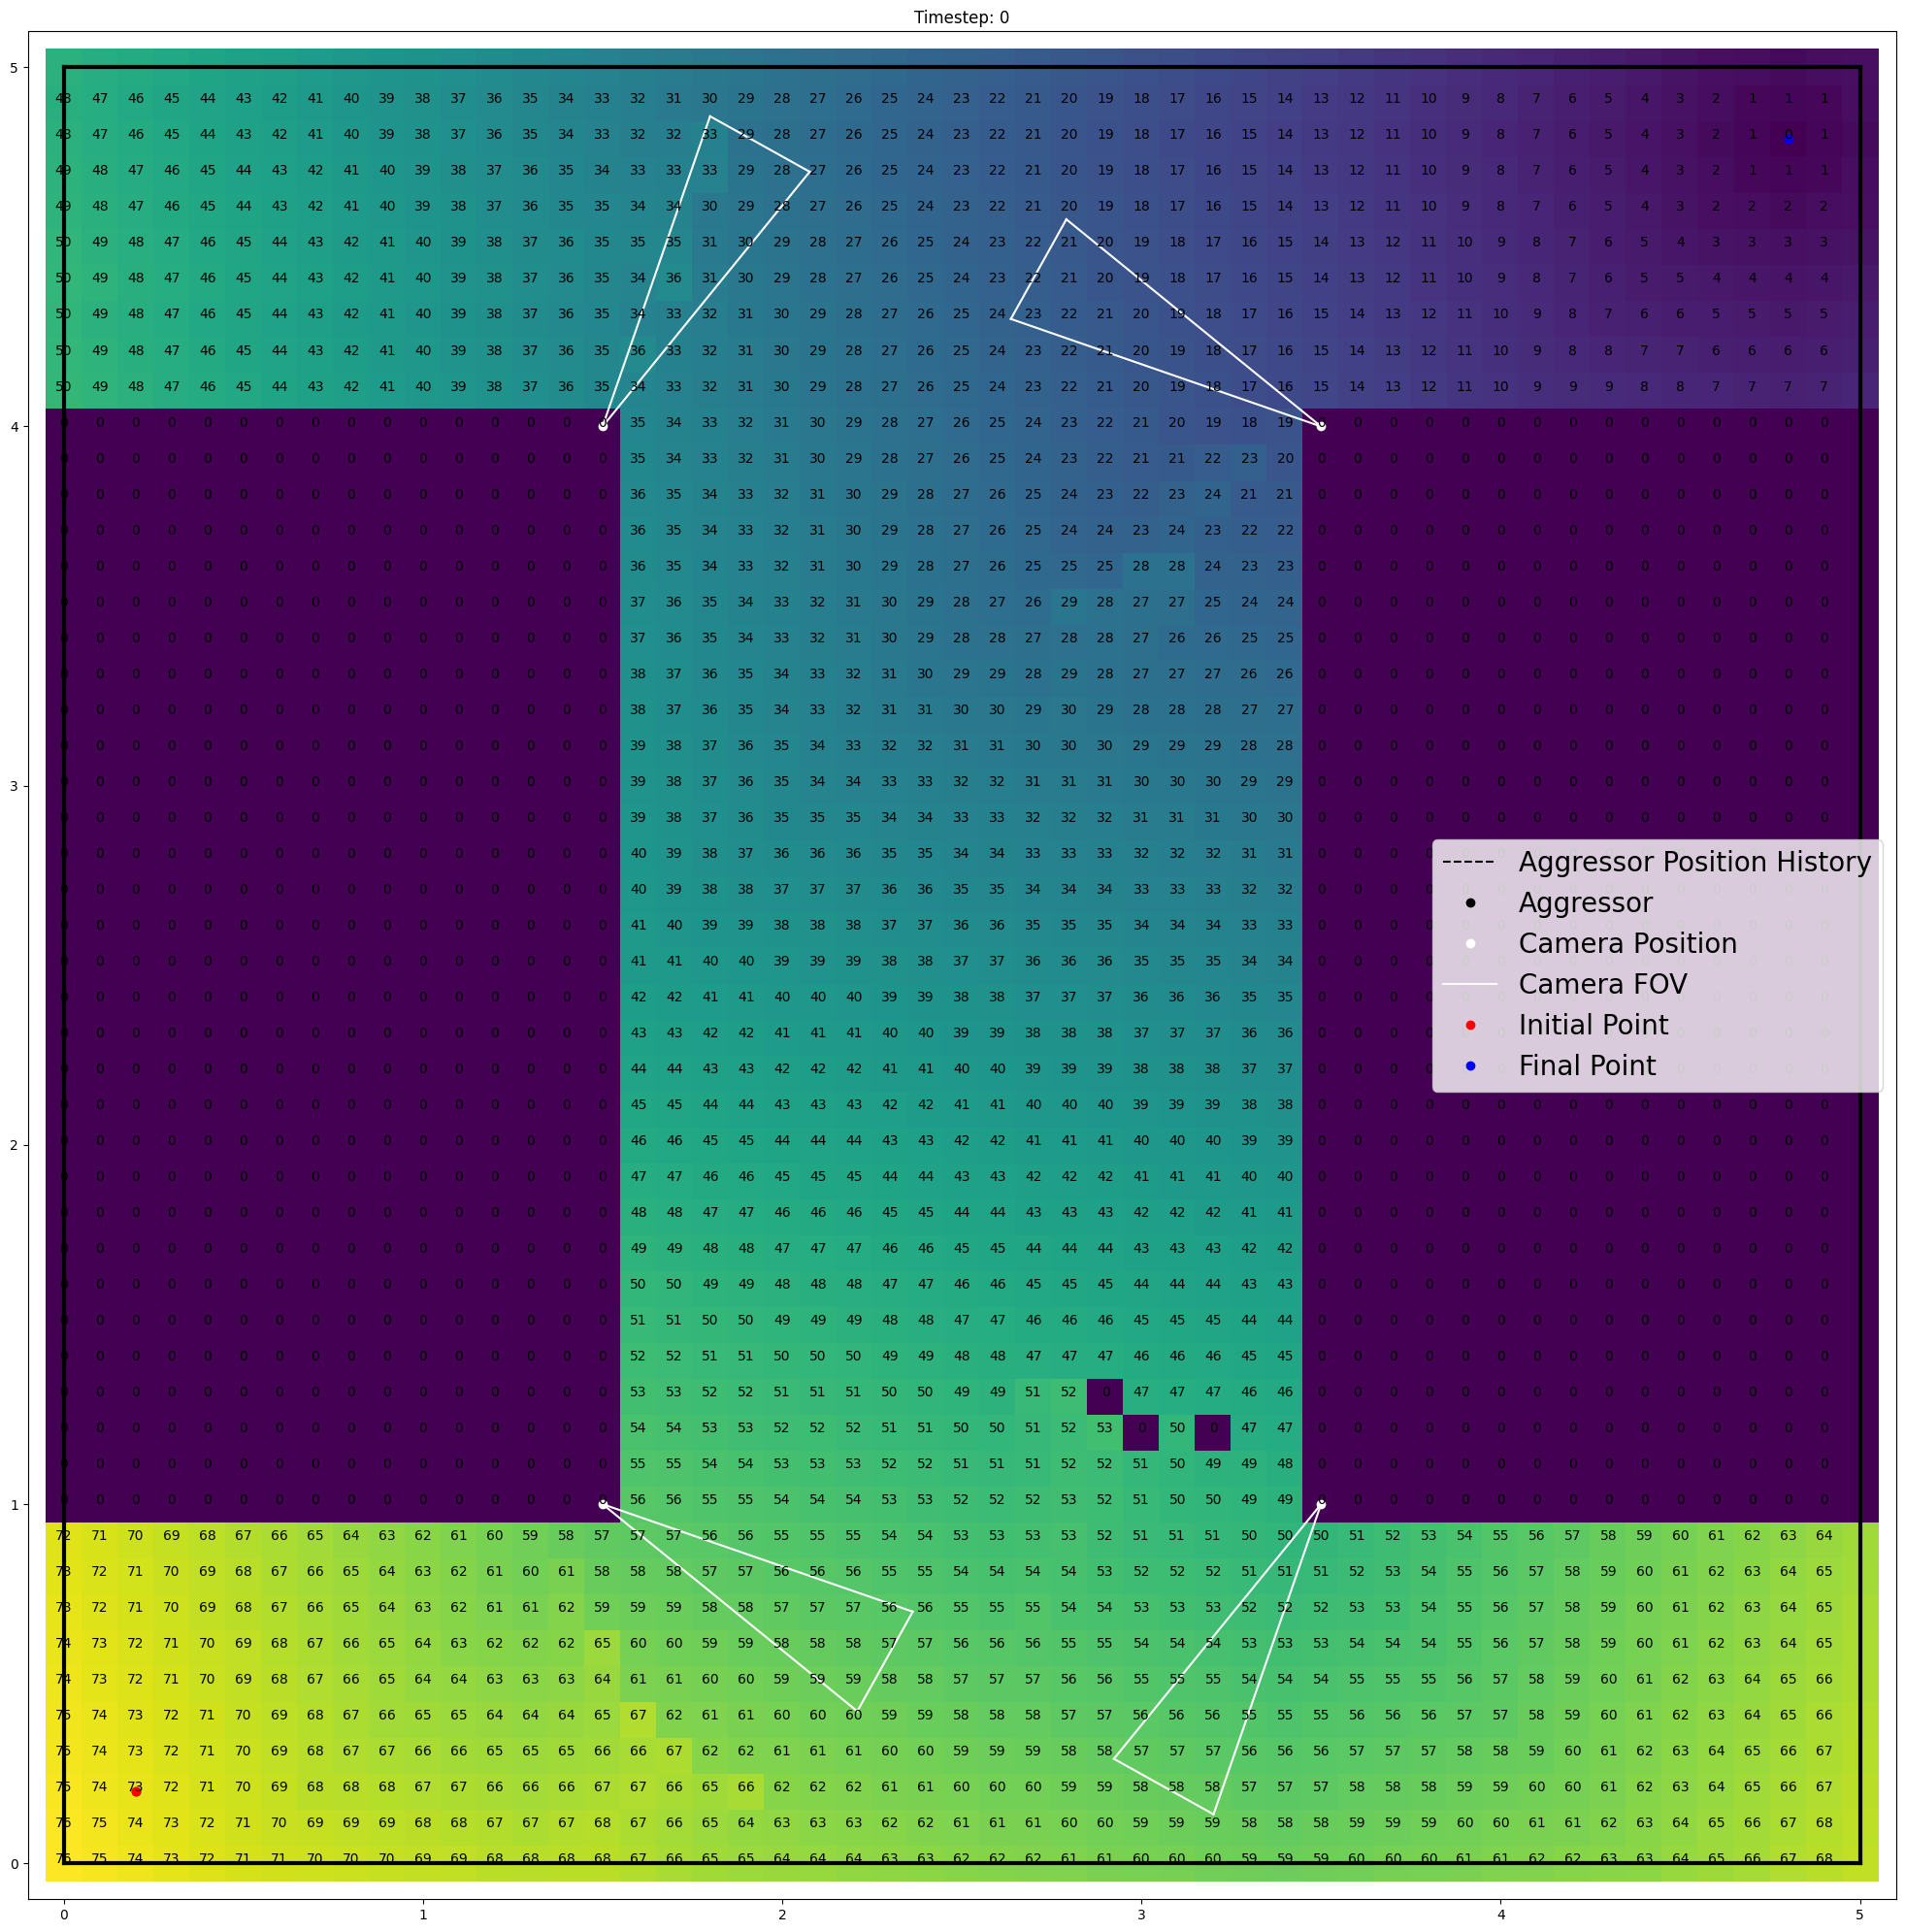

In [22]:
anim = anim_dyn_prog(V_data)
anim.save('Aggressor_Insertion_'+str(n_cam)+'Cam '+str(n)+' frame_Building_1.mp4', fps=5)

In [ ]:
nV = len(V_data)
nP = len(p_hist_opt)
fig = plt.figure(figsize=(x[-1]*inflate_camera_view, y[-1]*inflate_camera_view))
plt.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())   

i = nP-1

# Grid Coloring
plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[i].min(), vmax=V_data[i].max())

# Node Population
# Find current index from dictionary and plot populated node
curr_key = str(i)
liveNode = live_hist[curr_key]
primaris = 0
for p in liveNode:
    cawl = position(p)
    plt.plot(cawl[0], cawl[1], 'xb', label='Live Node' if primaris == 0 else "")
    val = V_data[i][p[0], p[1]]
    #plt.text(cawl[0], cawl[1]+0.025, "%d" %val, ha="center")
    primaris += 1


    
for m in range(len(X)-1):
    for n in range(len(Y)-1):
        val = V_data[i][m, n]
        titan = position((m,n))
        plt.text(titan[0], titan[1], "%d" %val, ha="center")

v = i
plt.plot(pos_hist_opt[:v+1,0], pos_hist_opt[:v+1,1], '-k')
plt.plot(pos_hist_opt[v,0], pos_hist_opt[v,1], 'ow')
        
        
# Camera Visualization
for ind in range(n_cam):
    # Plot Camera Position
    plt.plot(campos[ind,0], campos[ind,1], 'ow', label='camera pos' if ind == 0 else "")

    # Plot Camera FOV
    k = end_in[ind]-i%len(tvec[ind])
    if k < 0:
        k = k + len(tvec[ind])-1
    elif k > len(tvec[ind]):
        k = k - len(tvec[ind])-1
    theta = camvec[ind, k]
    xend = campos[ind,0]+fov_rng*np.cos(theta)
    yend = campos[ind,1]+fov_rng*np.sin(theta)
    #plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

    # FOV LOS
    h = fov_rng*np.tan(fov_ang/2)
    Rprime = np.sqrt(h**2 + fov_rng**2)

    xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]+fov_ang/2)]
    yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]+fov_ang/2)]
    xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind, k]-fov_ang/2)]
    yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind, k]-fov_ang/2)]
    xprime3 = [campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2), campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
    yprime3 = [campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2), campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
    plt.plot(xprime1, yprime1, '-w')
    plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV' if ind == 0 else "")
    plt.plot(xprime3, yprime3, '-w')

for b in range(nB):
    bcoor = building[b]
    plt.plot([bcoor[0], bcoor[1]], [bcoor[2], bcoor[2]], '-k')
    plt.plot([bcoor[0], bcoor[1]], [bcoor[3], bcoor[3]], '-k')
    plt.plot([bcoor[0], bcoor[0]], [bcoor[2], bcoor[3]], '-k')
    plt.plot([bcoor[1], bcoor[1]], [bcoor[2], bcoor[3]], '-k')

# Plot x0, xf
plt.plot(x0[0], x0[1], 'or')
plt.plot(xf[0], xf[1], 'ob')

# Boxing the grid edge
# Horizontal
plt.plot([x[0], x[-1]], [y[0], y[0]], '-k', linewidth=3)
plt.plot([x[0], x[-1]], [y[-1], y[-1]], '-k', linewidth=3)
# Vertical
plt.plot([x[0], x[0]], [y[0], y[-1]], '-k', linewidth=3)
plt.plot([x[-1], x[-1]], [y[0], y[-1]], '-k', linewidth=3)

# Plot Settings
#plt.grid()
plt.axis('square')
tol = 0.1
plt.xlim(-tol, x[-1]+tol)
plt.ylim(-tol, y[-1]+tol)
plt.legend(loc="upper right")
plt.title("Timestep: {}".format(i))
plt.show()


temppos = pos_hist_opt[i]
tempp = p_hist_opt[i]

print(FOVtvec[i])
print(temppos)
print(tempp)
print(V_data[v][tempp[0], tempp[1]])

currV = V_data[i]
kiek = []
for a in movement:
    pax = tempp[0]+a[0]
    pay = tempp[1]+a[1]
    kiek.append(currV[pax, pay])
    
print(kiek)
min_ind = kiek.index(min(kiek))
print(min_ind)
print(movement[min_ind])

In [ ]:
## Quick test
import copy

# Initialize Final Point
i_x_prev = i_xf

commentTrigger = False
SanityCheck = type(None)

# Possible Actions
movement = [
    (1, 0), (-1, 0),  # Horizontal
    (0, 1), (0, -1),  # Vertical
    (0, 0)           # Stationary
    , (1, 1), (1, -1), (-1, 1), (-1, -1) # Diagonal
]

# Compute moves from current node
V_Omnissiah = {}
counter = 0
stop_trigger = True
p_hist = [i_xf]
serberys = end_in_prev
while stop_trigger:
    print("===========================")
    print("Iteration Counter: {}".format(counter))
    i_x = i_x_prev
    V = np.zeros((n, n))
    live = [[i_x[0], i_x[1]]]
    
    # Obtain propagation
    V_data = []
    kek = end_in
    while len(live) > 0:
        #print("Length of live: {}".format(len(live)))
        new = set()
        # Bound iteration between camvec
        serberys = kek
        for j in range(n_cam):
            if end_in_prev[j] > len(camvec[j]):
                end_in_prev[j] = end_in_prev[j] - len(camvec[j])
            elif end_in_prev[j] < 0:
                end_in_prev[j] = end_in_prev[j] + len(camvec[j])
        # Populate Node for cost function
        for p in live:
            for a in movement:
                # Obtain next movement pa
                pa = (p[0] - a[0], p[1] - a[1])

                # If our next move (pa) in current map in tk is valid,
                currkey = str(end_in_prev[0])
                if bound(pa) and check_map(pa, current_map[currkey]): 
                    #If pa is out of all camera bound
                    V_new = costfunc(p, pa) + V[p[0], p[1]]
                    V_old = V[pa[0], pa[1]]
                    if V_old == 0 or V_new < V_old:
                        V[pa[0], pa[1]] = V_new
                        new.add((pa[0], pa[1]))
                        temp = position(pa)
        live = new
        V_data.append(copy.copy(V))
        kek = serberys - 1
    
    print("Length V_data: {}".format(len(V_data)))
    
    V_data_Graph = True
    if V_data_Graph and counter%5 == 0:
        fig = plt.figure()
        plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    
    # Find optimal move for 1 step
    p = i_x0
    p_hist_opt = [p]
    count = 0
    while p != i_xf:
        # Generate Timestamp
        curr_time = count%len(camvec[0])
        next_time = curr_time + 1
        if next_time >= len(camvec[0]):
            next_time = next_time-len(camvec[0])
        
        pa_opt = None
        V_opt = None
        for a in movement:
            pa = (p[0] + a[0], p[1] + a[1])
            # Check Camera State
            # If our next move (pa) in current map in tk is valid,
            currkey = str(next_time)
            if bound(pa) and check_map(pa, current_map[currkey]):
                #If pa is out of all camera bound
                V_new = V[pa[0], pa[1]]
                if pa_opt is None or (V_new < V_opt):
                    V_opt = V_new
                    pa_opt = pa
            if pa == i_xf: break
        if count > 1000: break
        p = pa_opt
        # Check if p is empty
        # If p is empty: There is no solution exist s.t. x0 and xf can be connected without detection
        if isinstance(p, SanityCheck):
            break
        else:
            p_hist_opt.append(p)
            count += 1
    
    # What is new i_xf?
    print("Previous i_x: {}".format(i_x))
    i_x_prev = p_hist_opt[-2]
    print("New i_x: {}".format(i_x_prev))
        
    # Increment counter key and move to next step
    counter += 1
    p_hist.append(p_hist_opt[-2])
    # V_Omnissiah is a storage dictionary that stores V_data, started from i_xf
    # So its key 0 is actually a final time tf, a time we reach xf, NOT starting time t0
    # Final key counter would be a amount of timestamp taken
    V_Omnissiah[str(counter)] = V_data
    
    
    graph = False
    if graph:
        fig = plt.figure()
        plt.pcolor(X, Y, V_data[-1].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
        pos_hist = np.array([position(k) for k in p_hist])
        plt.plot(pos_hist[:,0], pos_hist[:,1], '-k')
        for ind in range(n_cam):
            # Plot Camera Position
            plt.plot(campos[ind,0], campos[ind,1], 'ow', label = 'Camera Position' if ind == 0 else "")

            # Plot Camera FOV
            k = end_in_prev[ind]-counter
            if k < 0:
                k = k + len(camvec[0])
            #print('i: {}, k: {}, end_in: {}'.format(i, k, end_in))
            theta = camvec[ind, k]
            xend = campos[ind,0]+fov_rng*np.cos(theta)
            yend = campos[ind,1]+fov_rng*np.sin(theta)
            plt.plot([campos[ind,0], xend], [campos[ind,1], yend], '--w')

            # FOV LOS
            h = fov_rng*np.tan(fov_ang/2)
            Rprime = np.sqrt(h**2 + fov_rng**2)

            xprime1 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]+fov_ang/2)]
            yprime1 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]+fov_ang/2)]
            xprime2 = [campos[ind,0], campos[ind,0]+Rprime*np.cos(camvec[ind,k]-fov_ang/2)]
            yprime2 = [campos[ind,1], campos[ind,1]+Rprime*np.sin(camvec[ind,k]-fov_ang/2)]
            plt.plot(xprime1, yprime1, '-w')
            plt.plot(xprime2, yprime2, '-w', label = 'Camera FOV' if ind == 0 else "")
        plt.show()
    
    if counter == 10:
        asdfasdfasf
    else:
        pass
    
print("Length V_data: {}".format(len(V_Omnissiah)))
